## Imports and Global initializations

In [1]:
import os
import random
import shutil
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset
from torch.utils.data.dataloader import DataLoader

import torchvision
from torchvision import models, transforms, datasets

import matplotlib.pyplot as plt
import time
import copy
from tqdm import tqdm

In [2]:
BATCH_SIZE = 16
NUM_EPOCHS = 100
LR = 0.001

In [3]:
random.seed(42)

In [4]:
def imshow(inp, title=None):
    """Imshow for Tensors."""
    inp = inp.numpy().transpose((1, 2, 0))
    plt.figure(figsize=(15, 15))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

In [5]:
print("Your working directory is: ", os.getcwd())
torch.manual_seed(0)

Your working directory is:  /home/student


In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [7]:
def count_and_vis(dataset, dataset_name):
    count_per_class = [0] * 10
    for row in dataset:
        count_per_class[row[1]]+=1
    print(f'The counts per class for {dataset_name} are:')
    print(count_per_class)
    
    fig, ax = plt.subplots(figsize=(20,10))
    ax.bar(class_names, count_per_class, color='blue')
    plt.title(f'Number of examples for each class in the {dataset_name}')
    plt.xlabel('classes', fontsize=12)
    plt.ylabel('count', fontsize=12)
    

## Original Data Exploratory

In [8]:
# Paths to original train and val directories
train_dir = os.path.join("old_data", "train")
val_dir = os.path.join("old_data", "val")

In [9]:
# Resize the samples and transform them into tensors
data_transforms = transforms.Compose([transforms.Resize([64, 64]), transforms.ToTensor()])

In [10]:
# Create a pytorch dataset from a directory of images
train_dataset = datasets.ImageFolder(train_dir, data_transforms)
val_dataset = datasets.ImageFolder(val_dir, data_transforms)

In [11]:
len(train_dataset)

2067

In addition we have 10 more examples, one for each class

In [12]:
class_names = train_dataset.classes
NUM_CLASSES = len(class_names)
print("The classes are: ", class_names)

The classes are:  ['i', 'ii', 'iii', 'iv', 'ix', 'v', 'vi', 'vii', 'viii', 'x']


The counts per class for original train dataset are:
[261, 157, 186, 281, 234, 196, 181, 193, 199, 179]


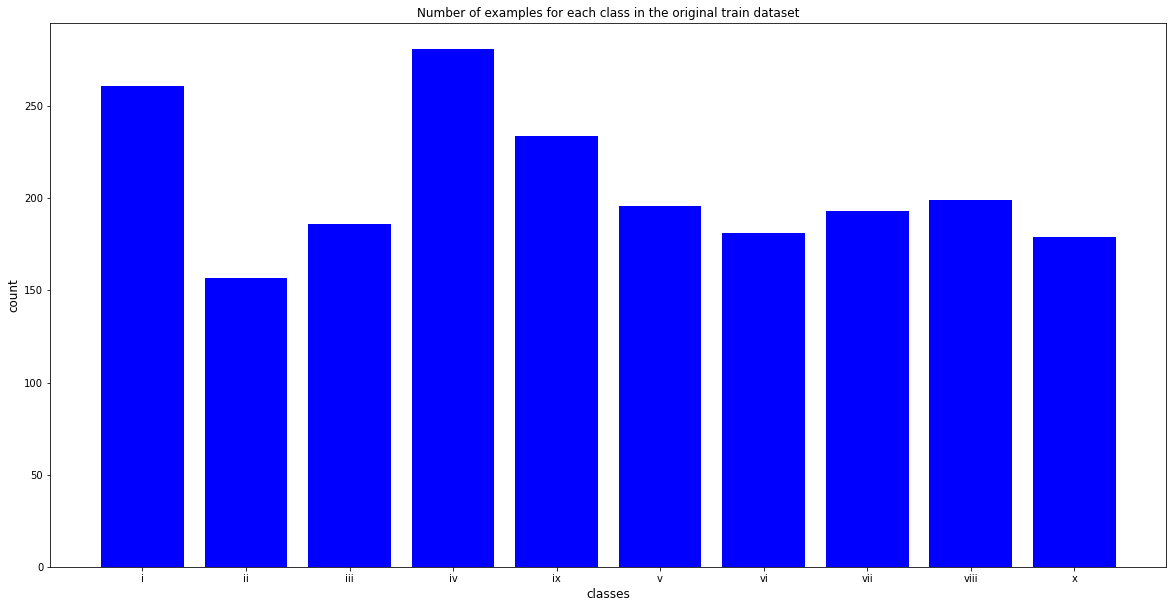

In [13]:
count_and_vis(train_dataset, 'original train dataset')

We don't apply this function on the original validation set because it has only 1 image per class.

## The model and the evaluation 

In [14]:
def train_model(model, criterion, optimizer, scheduler, dataloaders, dataset_sizes, num_epochs=100):
    """Responsible for running the training and validation phases for the requested model."""
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    loss_dict = {'train': [], 'val': []}
    acc_dict = {'train': [], 'val': []}

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            acc_dict[phase].append(epoch_acc.item())
            loss_dict[phase].append(epoch_loss)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
               phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)

    return model, loss_dict, acc_dict

In [15]:
def acc_loss_vis(loss_dict, acc_dict):
    # Basic visualizations of the model performance
    fig = plt.figure(figsize=(20,10))
    plt.title("Train - Validation Loss")
    plt.plot( loss_dict['train'], label='train')
    plt.plot(  loss_dict['val'], label='validation')
    plt.xlabel('num_epochs', fontsize=12)
    plt.ylabel('loss', fontsize=12)
    plt.legend(loc='best')
    plt.show()
#     plt.savefig('train_val_loss_plot.png')

    fig = plt.figure(figsize=(20,10))
    plt.title("Train - Validation ACC")
    plt.plot( acc_dict['train'], label='train')
    plt.plot(  acc_dict['val'], label='validation')
    plt.xlabel('num_epochs', fontsize=12)
    plt.ylabel('ACC', fontsize=12)
    plt.legend(loc='best')
    plt.show()
#     plt.savefig('train_val_acc_plot.png')

## Baseline 

In [16]:
baseline_data_path = 'baseline_data'
for class_name in os.listdir('old_data/train'):
    os.makedirs(f'{baseline_data_path}/train/{class_name}', exist_ok=True)
    os.makedirs(f'{baseline_data_path}/val/{class_name}', exist_ok=True)

In [17]:
# move from train to val some of the images and some keep in n
for class_name in os.listdir(f'old_data/train'):
    files_names = os.listdir(f'old_data/train/{class_name}')
    random.shuffle(files_names)
    n_images = int(0.2 * (len(files_names) + 1))
    for file_name in files_names[:n_images]:
        shutil.copy(f'old_data/train/{class_name}/{file_name}', f'{baseline_data_path}/val/{class_name}/{file_name}')
    for file_name in files_names[n_images:]:
        shutil.copy(f'old_data/train/{class_name}/{file_name}', f'{baseline_data_path}/train/{class_name}/{file_name}')

for class_name in os.listdir('old_data/val'):
    for file_name in os.listdir(f'old_data/val/{class_name}'):
        shutil.copy(f'old_data/val/{class_name}/{file_name}', f'{baseline_data_path}/val/{class_name}/{file_name}')

In [18]:
# Paths to baseline train and val directories
baseline_train_dir = os.path.join("baseline_data", "train")
baseline_val_dir = os.path.join("baseline_data", "val")

In [19]:
# Create a pytorch dataset from a directory of images
baseline_train_dataset = datasets.ImageFolder(baseline_train_dir, data_transforms)
baseline_val_dataset = datasets.ImageFolder(baseline_val_dir, data_transforms)

In [20]:
baseline_train_len = len(baseline_train_dataset)
print(f'The length of the baseline train dataset is: {baseline_train_len}')
baseline_val_len = len(baseline_val_dataset)
print(f'The length of the baseline validation dataset is: {baseline_val_len}')

The length of the baseline train dataset is: 1655
The length of the baseline validation dataset is: 422


The counts per class for baseline train dataset are:
[209, 126, 149, 225, 187, 157, 145, 155, 159, 143]


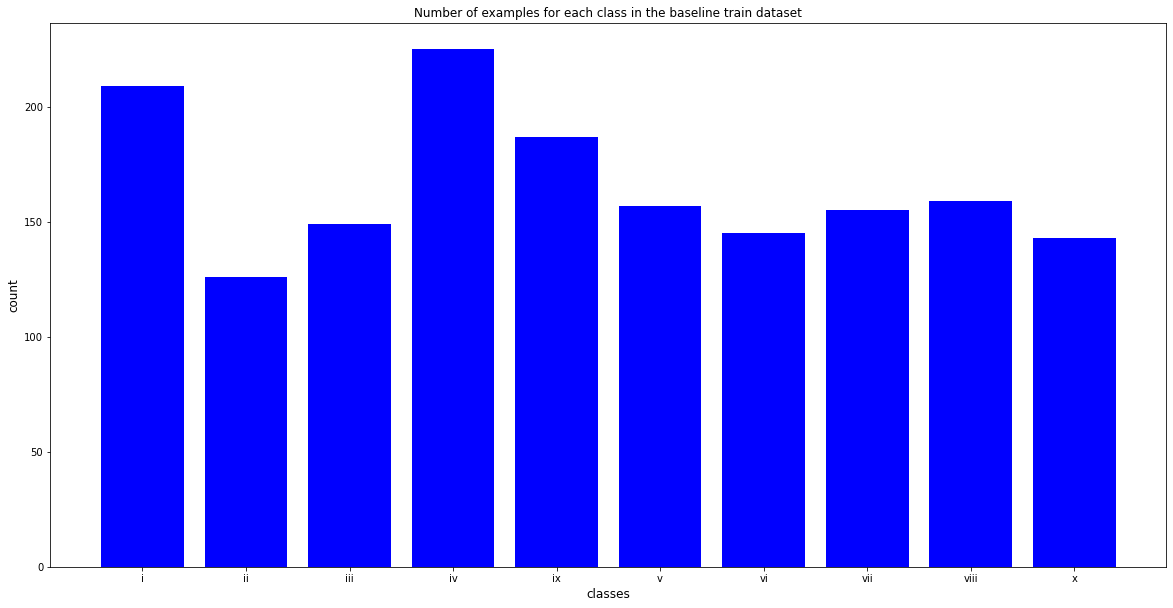

In [21]:
count_and_vis(baseline_train_dataset, 'baseline train dataset')

The counts per class for baseline validation dataset are:
[53, 32, 38, 57, 48, 40, 37, 39, 41, 37]


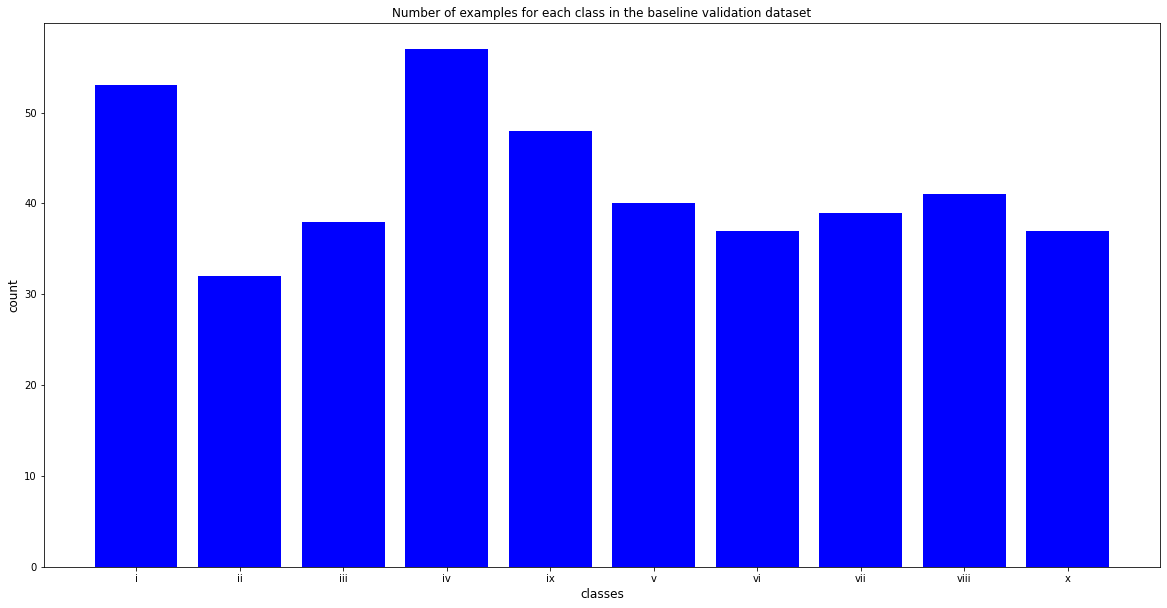

In [22]:
count_and_vis(baseline_val_dataset, 'baseline validation dataset')

In [23]:
# Use a prebuilt pytorch's ResNet50 model
model_ft = models.resnet50(pretrained=False)

# Fit the last layer for our specific task
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, NUM_CLASSES)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.Adam(model_ft.parameters(), lr=LR)

# Decay LR by a factor of 0.1 every 5 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.1)

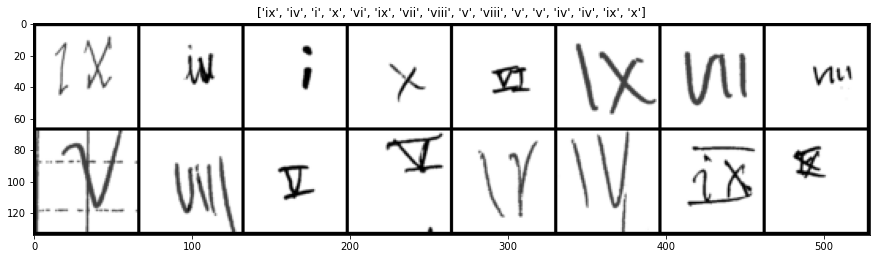

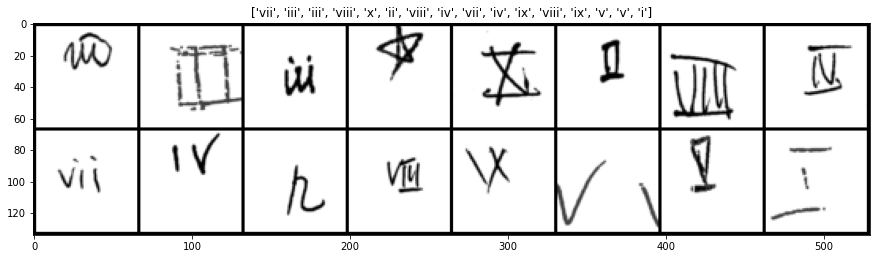

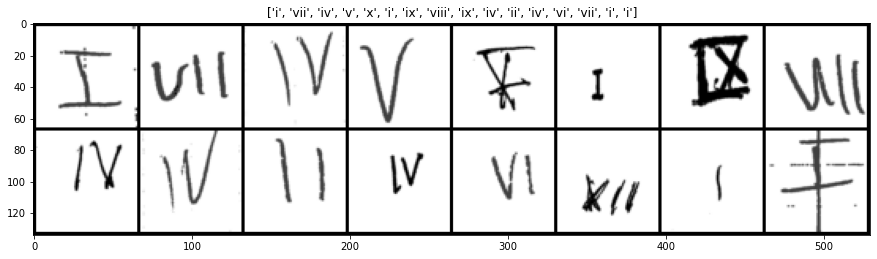

Epoch 1/100
----------


100%|█████████████████████████████████████████| 104/104 [00:09<00:00, 11.43it/s]


train Loss: 2.6565 Acc: 0.1837


100%|███████████████████████████████████████████| 27/27 [00:00<00:00, 31.33it/s]


val Loss: 2.4778 Acc: 0.3104

Epoch 2/100
----------


100%|█████████████████████████████████████████| 104/104 [00:08<00:00, 12.16it/s]


train Loss: 1.9771 Acc: 0.3444


100%|███████████████████████████████████████████| 27/27 [00:00<00:00, 30.98it/s]


val Loss: 1.5860 Acc: 0.4550

Epoch 3/100
----------


100%|█████████████████████████████████████████| 104/104 [00:08<00:00, 12.29it/s]


train Loss: 1.4987 Acc: 0.5154


100%|███████████████████████████████████████████| 27/27 [00:00<00:00, 30.42it/s]


val Loss: 1.3216 Acc: 0.5308

Epoch 4/100
----------


100%|█████████████████████████████████████████| 104/104 [00:08<00:00, 12.25it/s]


train Loss: 1.2321 Acc: 0.6054


100%|███████████████████████████████████████████| 27/27 [00:00<00:00, 30.57it/s]


val Loss: 1.1337 Acc: 0.5900

Epoch 5/100
----------


100%|█████████████████████████████████████████| 104/104 [00:08<00:00, 12.24it/s]


train Loss: 1.0601 Acc: 0.6604


100%|███████████████████████████████████████████| 27/27 [00:00<00:00, 31.35it/s]


val Loss: 1.1822 Acc: 0.6209

Epoch 6/100
----------


100%|█████████████████████████████████████████| 104/104 [00:08<00:00, 12.17it/s]


train Loss: 0.6769 Acc: 0.7764


100%|███████████████████████████████████████████| 27/27 [00:00<00:00, 31.28it/s]


val Loss: 0.6822 Acc: 0.7986

Epoch 7/100
----------


100%|█████████████████████████████████████████| 104/104 [00:08<00:00, 12.26it/s]


train Loss: 0.4967 Acc: 0.8393


100%|███████████████████████████████████████████| 27/27 [00:00<00:00, 30.48it/s]


val Loss: 0.6502 Acc: 0.8175

Epoch 8/100
----------


100%|█████████████████████████████████████████| 104/104 [00:08<00:00, 11.95it/s]


train Loss: 0.4149 Acc: 0.8659


100%|███████████████████████████████████████████| 27/27 [00:00<00:00, 29.50it/s]


val Loss: 0.6650 Acc: 0.8009

Epoch 9/100
----------


100%|█████████████████████████████████████████| 104/104 [00:08<00:00, 12.29it/s]


train Loss: 0.3441 Acc: 0.8900


100%|███████████████████████████████████████████| 27/27 [00:00<00:00, 27.70it/s]


val Loss: 0.6646 Acc: 0.8057

Epoch 10/100
----------


100%|█████████████████████████████████████████| 104/104 [00:08<00:00, 12.01it/s]


train Loss: 0.2614 Acc: 0.9178


100%|███████████████████████████████████████████| 27/27 [00:00<00:00, 29.88it/s]


val Loss: 0.6841 Acc: 0.8294

Epoch 11/100
----------


100%|█████████████████████████████████████████| 104/104 [00:08<00:00, 11.98it/s]


train Loss: 0.1912 Acc: 0.9480


100%|███████████████████████████████████████████| 27/27 [00:00<00:00, 29.80it/s]


val Loss: 0.6558 Acc: 0.8365

Epoch 12/100
----------


100%|█████████████████████████████████████████| 104/104 [00:08<00:00, 11.99it/s]


train Loss: 0.1617 Acc: 0.9553


100%|███████████████████████████████████████████| 27/27 [00:00<00:00, 30.33it/s]


val Loss: 0.6446 Acc: 0.8318

Epoch 13/100
----------


100%|█████████████████████████████████████████| 104/104 [00:08<00:00, 12.29it/s]


train Loss: 0.1466 Acc: 0.9631


100%|███████████████████████████████████████████| 27/27 [00:00<00:00, 29.81it/s]


val Loss: 0.6649 Acc: 0.8412

Epoch 14/100
----------


100%|█████████████████████████████████████████| 104/104 [00:08<00:00, 12.19it/s]


train Loss: 0.1458 Acc: 0.9644


100%|███████████████████████████████████████████| 27/27 [00:00<00:00, 31.19it/s]


val Loss: 0.6655 Acc: 0.8365

Epoch 15/100
----------


100%|█████████████████████████████████████████| 104/104 [00:08<00:00, 12.38it/s]


train Loss: 0.1337 Acc: 0.9662


100%|███████████████████████████████████████████| 27/27 [00:00<00:00, 31.72it/s]


val Loss: 0.6729 Acc: 0.8412

Epoch 16/100
----------


100%|█████████████████████████████████████████| 104/104 [00:08<00:00, 12.37it/s]


train Loss: 0.1334 Acc: 0.9631


100%|███████████████████████████████████████████| 27/27 [00:00<00:00, 31.56it/s]


val Loss: 0.7000 Acc: 0.8389

Epoch 17/100
----------


100%|█████████████████████████████████████████| 104/104 [00:08<00:00, 12.36it/s]


train Loss: 0.1302 Acc: 0.9650


100%|███████████████████████████████████████████| 27/27 [00:00<00:00, 31.65it/s]


val Loss: 0.6823 Acc: 0.8389

Epoch 18/100
----------


100%|█████████████████████████████████████████| 104/104 [00:08<00:00, 12.40it/s]


train Loss: 0.1402 Acc: 0.9607


100%|███████████████████████████████████████████| 27/27 [00:00<00:00, 31.55it/s]


val Loss: 0.7007 Acc: 0.8483

Epoch 19/100
----------


100%|█████████████████████████████████████████| 104/104 [00:08<00:00, 12.26it/s]


train Loss: 0.1255 Acc: 0.9631


100%|███████████████████████████████████████████| 27/27 [00:00<00:00, 31.61it/s]


val Loss: 0.6738 Acc: 0.8436

Epoch 20/100
----------


100%|█████████████████████████████████████████| 104/104 [00:08<00:00, 12.38it/s]


train Loss: 0.1239 Acc: 0.9710


100%|███████████████████████████████████████████| 27/27 [00:00<00:00, 31.27it/s]


val Loss: 0.7183 Acc: 0.8318

Epoch 21/100
----------


100%|█████████████████████████████████████████| 104/104 [00:08<00:00, 12.37it/s]


train Loss: 0.1348 Acc: 0.9686


100%|███████████████████████████████████████████| 27/27 [00:00<00:00, 31.29it/s]


val Loss: 0.7097 Acc: 0.8412

Epoch 22/100
----------


100%|█████████████████████████████████████████| 104/104 [00:08<00:00, 12.40it/s]


train Loss: 0.1337 Acc: 0.9644


100%|███████████████████████████████████████████| 27/27 [00:00<00:00, 31.02it/s]


val Loss: 0.6862 Acc: 0.8365

Epoch 23/100
----------


100%|█████████████████████████████████████████| 104/104 [00:08<00:00, 12.27it/s]


train Loss: 0.1277 Acc: 0.9686


100%|███████████████████████████████████████████| 27/27 [00:00<00:00, 31.69it/s]


val Loss: 0.6883 Acc: 0.8436

Epoch 24/100
----------


100%|█████████████████████████████████████████| 104/104 [00:08<00:00, 12.35it/s]


train Loss: 0.1205 Acc: 0.9680


100%|███████████████████████████████████████████| 27/27 [00:00<00:00, 31.33it/s]


val Loss: 0.7075 Acc: 0.8318

Epoch 25/100
----------


100%|█████████████████████████████████████████| 104/104 [00:08<00:00, 12.31it/s]


train Loss: 0.1281 Acc: 0.9644


100%|███████████████████████████████████████████| 27/27 [00:00<00:00, 30.98it/s]


val Loss: 0.7038 Acc: 0.8318

Epoch 26/100
----------


100%|█████████████████████████████████████████| 104/104 [00:08<00:00, 12.28it/s]


train Loss: 0.1194 Acc: 0.9716


100%|███████████████████████████████████████████| 27/27 [00:00<00:00, 30.89it/s]


val Loss: 0.6901 Acc: 0.8436

Epoch 27/100
----------


100%|█████████████████████████████████████████| 104/104 [00:08<00:00, 12.32it/s]


train Loss: 0.1252 Acc: 0.9698


100%|███████████████████████████████████████████| 27/27 [00:00<00:00, 30.72it/s]


val Loss: 0.7007 Acc: 0.8389

Epoch 28/100
----------


100%|█████████████████████████████████████████| 104/104 [00:08<00:00, 12.32it/s]


train Loss: 0.1298 Acc: 0.9674


100%|███████████████████████████████████████████| 27/27 [00:00<00:00, 31.00it/s]


val Loss: 0.7106 Acc: 0.8436

Epoch 29/100
----------


100%|█████████████████████████████████████████| 104/104 [00:08<00:00, 12.31it/s]


train Loss: 0.1285 Acc: 0.9674


100%|███████████████████████████████████████████| 27/27 [00:00<00:00, 31.42it/s]


val Loss: 0.6933 Acc: 0.8389

Epoch 30/100
----------


100%|█████████████████████████████████████████| 104/104 [00:08<00:00, 12.29it/s]


train Loss: 0.1212 Acc: 0.9644


100%|███████████████████████████████████████████| 27/27 [00:00<00:00, 30.78it/s]


val Loss: 0.6751 Acc: 0.8460

Epoch 31/100
----------


100%|█████████████████████████████████████████| 104/104 [00:08<00:00, 12.46it/s]


train Loss: 0.1266 Acc: 0.9668


100%|███████████████████████████████████████████| 27/27 [00:00<00:00, 31.61it/s]


val Loss: 0.6993 Acc: 0.8436

Epoch 32/100
----------


100%|█████████████████████████████████████████| 104/104 [00:08<00:00, 12.18it/s]


train Loss: 0.1222 Acc: 0.9692


100%|███████████████████████████████████████████| 27/27 [00:00<00:00, 31.21it/s]


val Loss: 0.6807 Acc: 0.8412

Epoch 33/100
----------


100%|█████████████████████████████████████████| 104/104 [00:08<00:00, 12.31it/s]


train Loss: 0.1354 Acc: 0.9607


100%|███████████████████████████████████████████| 27/27 [00:00<00:00, 31.14it/s]


val Loss: 0.6908 Acc: 0.8436

Epoch 34/100
----------


100%|█████████████████████████████████████████| 104/104 [00:08<00:00, 12.30it/s]


train Loss: 0.1236 Acc: 0.9656


100%|███████████████████████████████████████████| 27/27 [00:00<00:00, 30.67it/s]


val Loss: 0.6945 Acc: 0.8365

Epoch 35/100
----------


100%|█████████████████████████████████████████| 104/104 [00:08<00:00, 12.34it/s]


train Loss: 0.1282 Acc: 0.9680


100%|███████████████████████████████████████████| 27/27 [00:00<00:00, 30.95it/s]


val Loss: 0.6880 Acc: 0.8436

Epoch 36/100
----------


100%|█████████████████████████████████████████| 104/104 [00:08<00:00, 12.31it/s]


train Loss: 0.1291 Acc: 0.9583


100%|███████████████████████████████████████████| 27/27 [00:00<00:00, 31.50it/s]


val Loss: 0.7112 Acc: 0.8341

Epoch 37/100
----------


100%|█████████████████████████████████████████| 104/104 [00:08<00:00, 12.42it/s]


train Loss: 0.1290 Acc: 0.9692


100%|███████████████████████████████████████████| 27/27 [00:00<00:00, 31.32it/s]


val Loss: 0.6823 Acc: 0.8365

Epoch 38/100
----------


100%|█████████████████████████████████████████| 104/104 [00:08<00:00, 12.35it/s]


train Loss: 0.1301 Acc: 0.9686


100%|███████████████████████████████████████████| 27/27 [00:00<00:00, 31.31it/s]


val Loss: 0.7138 Acc: 0.8270

Epoch 39/100
----------


100%|█████████████████████████████████████████| 104/104 [00:08<00:00, 12.29it/s]


train Loss: 0.1183 Acc: 0.9704


100%|███████████████████████████████████████████| 27/27 [00:00<00:00, 31.05it/s]


val Loss: 0.6936 Acc: 0.8341

Epoch 40/100
----------


100%|█████████████████████████████████████████| 104/104 [00:08<00:00, 12.30it/s]


train Loss: 0.1328 Acc: 0.9662


100%|███████████████████████████████████████████| 27/27 [00:00<00:00, 29.99it/s]


val Loss: 0.6690 Acc: 0.8412

Epoch 41/100
----------


100%|█████████████████████████████████████████| 104/104 [00:08<00:00, 12.25it/s]


train Loss: 0.1236 Acc: 0.9680


100%|███████████████████████████████████████████| 27/27 [00:00<00:00, 30.44it/s]


val Loss: 0.6832 Acc: 0.8341

Epoch 42/100
----------


100%|█████████████████████████████████████████| 104/104 [00:08<00:00, 12.34it/s]


train Loss: 0.1189 Acc: 0.9656


100%|███████████████████████████████████████████| 27/27 [00:00<00:00, 30.89it/s]


val Loss: 0.6783 Acc: 0.8436

Epoch 43/100
----------


100%|█████████████████████████████████████████| 104/104 [00:08<00:00, 12.14it/s]


train Loss: 0.1343 Acc: 0.9619


100%|███████████████████████████████████████████| 27/27 [00:00<00:00, 30.19it/s]


val Loss: 0.6789 Acc: 0.8436

Epoch 44/100
----------


100%|█████████████████████████████████████████| 104/104 [00:08<00:00, 12.35it/s]


train Loss: 0.1385 Acc: 0.9631


100%|███████████████████████████████████████████| 27/27 [00:00<00:00, 30.64it/s]


val Loss: 0.6843 Acc: 0.8412

Epoch 45/100
----------


100%|█████████████████████████████████████████| 104/104 [00:08<00:00, 12.35it/s]


train Loss: 0.1246 Acc: 0.9680


100%|███████████████████████████████████████████| 27/27 [00:00<00:00, 31.32it/s]


val Loss: 0.6795 Acc: 0.8318

Epoch 46/100
----------


100%|█████████████████████████████████████████| 104/104 [00:08<00:00, 12.39it/s]


train Loss: 0.1281 Acc: 0.9680


100%|███████████████████████████████████████████| 27/27 [00:00<00:00, 31.06it/s]


val Loss: 0.6798 Acc: 0.8412

Epoch 47/100
----------


100%|█████████████████████████████████████████| 104/104 [00:08<00:00, 12.35it/s]


train Loss: 0.1228 Acc: 0.9650


100%|███████████████████████████████████████████| 27/27 [00:00<00:00, 31.51it/s]


val Loss: 0.7002 Acc: 0.8389

Epoch 48/100
----------


100%|█████████████████████████████████████████| 104/104 [00:08<00:00, 12.42it/s]


train Loss: 0.1244 Acc: 0.9716


100%|███████████████████████████████████████████| 27/27 [00:00<00:00, 31.60it/s]


val Loss: 0.6896 Acc: 0.8341

Epoch 49/100
----------


100%|█████████████████████████████████████████| 104/104 [00:08<00:00, 12.29it/s]


train Loss: 0.1247 Acc: 0.9704


100%|███████████████████████████████████████████| 27/27 [00:00<00:00, 31.61it/s]


val Loss: 0.6642 Acc: 0.8341

Epoch 50/100
----------


100%|█████████████████████████████████████████| 104/104 [00:08<00:00, 12.21it/s]


train Loss: 0.1220 Acc: 0.9656


100%|███████████████████████████████████████████| 27/27 [00:00<00:00, 31.06it/s]


val Loss: 0.6899 Acc: 0.8436

Epoch 51/100
----------


100%|█████████████████████████████████████████| 104/104 [00:08<00:00, 12.30it/s]


train Loss: 0.1386 Acc: 0.9577


100%|███████████████████████████████████████████| 27/27 [00:00<00:00, 31.66it/s]


val Loss: 0.6881 Acc: 0.8389

Epoch 52/100
----------


100%|█████████████████████████████████████████| 104/104 [00:08<00:00, 12.41it/s]


train Loss: 0.1165 Acc: 0.9680


100%|███████████████████████████████████████████| 27/27 [00:00<00:00, 31.29it/s]


val Loss: 0.6770 Acc: 0.8412

Epoch 53/100
----------


100%|█████████████████████████████████████████| 104/104 [00:08<00:00, 12.35it/s]


train Loss: 0.1209 Acc: 0.9722


100%|███████████████████████████████████████████| 27/27 [00:00<00:00, 31.12it/s]


val Loss: 0.6962 Acc: 0.8412

Epoch 54/100
----------


100%|█████████████████████████████████████████| 104/104 [00:08<00:00, 12.34it/s]


train Loss: 0.1259 Acc: 0.9680


100%|███████████████████████████████████████████| 27/27 [00:00<00:00, 31.54it/s]


val Loss: 0.6850 Acc: 0.8318

Epoch 55/100
----------


100%|█████████████████████████████████████████| 104/104 [00:08<00:00, 12.27it/s]


train Loss: 0.1271 Acc: 0.9637


100%|███████████████████████████████████████████| 27/27 [00:00<00:00, 30.07it/s]


val Loss: 0.6962 Acc: 0.8412

Epoch 56/100
----------


100%|█████████████████████████████████████████| 104/104 [00:08<00:00, 12.23it/s]


train Loss: 0.1239 Acc: 0.9668


100%|███████████████████████████████████████████| 27/27 [00:00<00:00, 31.70it/s]


val Loss: 0.6884 Acc: 0.8412

Epoch 57/100
----------


100%|█████████████████████████████████████████| 104/104 [00:08<00:00, 12.32it/s]


train Loss: 0.1138 Acc: 0.9716


100%|███████████████████████████████████████████| 27/27 [00:00<00:00, 31.00it/s]


val Loss: 0.7046 Acc: 0.8365

Epoch 58/100
----------


100%|█████████████████████████████████████████| 104/104 [00:08<00:00, 12.14it/s]


train Loss: 0.1319 Acc: 0.9686


100%|███████████████████████████████████████████| 27/27 [00:00<00:00, 31.19it/s]


val Loss: 0.6910 Acc: 0.8341

Epoch 59/100
----------


100%|█████████████████████████████████████████| 104/104 [00:08<00:00, 12.17it/s]


train Loss: 0.1207 Acc: 0.9686


100%|███████████████████████████████████████████| 27/27 [00:00<00:00, 31.69it/s]


val Loss: 0.6864 Acc: 0.8460

Epoch 60/100
----------


100%|█████████████████████████████████████████| 104/104 [00:08<00:00, 12.16it/s]


train Loss: 0.1348 Acc: 0.9625


100%|███████████████████████████████████████████| 27/27 [00:00<00:00, 30.27it/s]


val Loss: 0.6767 Acc: 0.8436

Epoch 61/100
----------


100%|█████████████████████████████████████████| 104/104 [00:08<00:00, 12.12it/s]


train Loss: 0.1161 Acc: 0.9686


100%|███████████████████████████████████████████| 27/27 [00:00<00:00, 31.05it/s]


val Loss: 0.6750 Acc: 0.8389

Epoch 62/100
----------


100%|█████████████████████████████████████████| 104/104 [00:08<00:00, 12.39it/s]


train Loss: 0.1221 Acc: 0.9680


100%|███████████████████████████████████████████| 27/27 [00:00<00:00, 30.49it/s]


val Loss: 0.6953 Acc: 0.8460

Epoch 63/100
----------


100%|█████████████████████████████████████████| 104/104 [00:08<00:00, 12.39it/s]


train Loss: 0.1282 Acc: 0.9625


100%|███████████████████████████████████████████| 27/27 [00:00<00:00, 31.66it/s]


val Loss: 0.6916 Acc: 0.8365

Epoch 64/100
----------


100%|█████████████████████████████████████████| 104/104 [00:08<00:00, 12.27it/s]


train Loss: 0.1213 Acc: 0.9698


100%|███████████████████████████████████████████| 27/27 [00:00<00:00, 31.36it/s]


val Loss: 0.6973 Acc: 0.8365

Epoch 65/100
----------


100%|█████████████████████████████████████████| 104/104 [00:08<00:00, 12.38it/s]


train Loss: 0.1326 Acc: 0.9692


100%|███████████████████████████████████████████| 27/27 [00:00<00:00, 31.69it/s]


val Loss: 0.7118 Acc: 0.8365

Epoch 66/100
----------


100%|█████████████████████████████████████████| 104/104 [00:08<00:00, 12.38it/s]


train Loss: 0.1228 Acc: 0.9680


100%|███████████████████████████████████████████| 27/27 [00:00<00:00, 31.33it/s]


val Loss: 0.7053 Acc: 0.8341

Epoch 67/100
----------


100%|█████████████████████████████████████████| 104/104 [00:08<00:00, 12.35it/s]


train Loss: 0.1178 Acc: 0.9686


100%|███████████████████████████████████████████| 27/27 [00:00<00:00, 30.89it/s]


val Loss: 0.7042 Acc: 0.8341

Epoch 68/100
----------


100%|█████████████████████████████████████████| 104/104 [00:08<00:00, 12.28it/s]


train Loss: 0.1227 Acc: 0.9716


100%|███████████████████████████████████████████| 27/27 [00:00<00:00, 30.79it/s]


val Loss: 0.7288 Acc: 0.8341

Epoch 69/100
----------


100%|█████████████████████████████████████████| 104/104 [00:08<00:00, 12.36it/s]


train Loss: 0.1244 Acc: 0.9692


100%|███████████████████████████████████████████| 27/27 [00:00<00:00, 31.29it/s]


val Loss: 0.6955 Acc: 0.8341

Epoch 70/100
----------


100%|█████████████████████████████████████████| 104/104 [00:08<00:00, 12.33it/s]


train Loss: 0.1317 Acc: 0.9644


100%|███████████████████████████████████████████| 27/27 [00:00<00:00, 31.33it/s]


val Loss: 0.6784 Acc: 0.8436

Epoch 71/100
----------


100%|█████████████████████████████████████████| 104/104 [00:08<00:00, 12.09it/s]


train Loss: 0.1312 Acc: 0.9644


100%|███████████████████████████████████████████| 27/27 [00:00<00:00, 31.38it/s]


val Loss: 0.6986 Acc: 0.8436

Epoch 72/100
----------


100%|█████████████████████████████████████████| 104/104 [00:08<00:00, 12.30it/s]


train Loss: 0.1365 Acc: 0.9619


100%|███████████████████████████████████████████| 27/27 [00:00<00:00, 31.17it/s]


val Loss: 0.6876 Acc: 0.8389

Epoch 73/100
----------


100%|█████████████████████████████████████████| 104/104 [00:08<00:00, 11.91it/s]


train Loss: 0.1097 Acc: 0.9752


100%|███████████████████████████████████████████| 27/27 [00:00<00:00, 29.41it/s]


val Loss: 0.6822 Acc: 0.8412

Epoch 74/100
----------


100%|█████████████████████████████████████████| 104/104 [00:08<00:00, 12.22it/s]


train Loss: 0.1231 Acc: 0.9650


100%|███████████████████████████████████████████| 27/27 [00:00<00:00, 30.58it/s]


val Loss: 0.7084 Acc: 0.8294

Epoch 75/100
----------


100%|█████████████████████████████████████████| 104/104 [00:08<00:00, 12.29it/s]


train Loss: 0.1244 Acc: 0.9662


100%|███████████████████████████████████████████| 27/27 [00:00<00:00, 31.53it/s]


val Loss: 0.6937 Acc: 0.8365

Epoch 76/100
----------


100%|█████████████████████████████████████████| 104/104 [00:08<00:00, 12.40it/s]


train Loss: 0.1279 Acc: 0.9650


100%|███████████████████████████████████████████| 27/27 [00:00<00:00, 30.49it/s]


val Loss: 0.6961 Acc: 0.8389

Epoch 77/100
----------


100%|█████████████████████████████████████████| 104/104 [00:08<00:00, 12.42it/s]


train Loss: 0.1131 Acc: 0.9716


100%|███████████████████████████████████████████| 27/27 [00:00<00:00, 30.89it/s]


val Loss: 0.6719 Acc: 0.8412

Epoch 78/100
----------


100%|█████████████████████████████████████████| 104/104 [00:08<00:00, 12.40it/s]


train Loss: 0.1246 Acc: 0.9656


100%|███████████████████████████████████████████| 27/27 [00:00<00:00, 30.88it/s]


val Loss: 0.6804 Acc: 0.8436

Epoch 79/100
----------


100%|█████████████████████████████████████████| 104/104 [00:08<00:00, 12.38it/s]


train Loss: 0.1150 Acc: 0.9710


100%|███████████████████████████████████████████| 27/27 [00:00<00:00, 31.08it/s]


val Loss: 0.6866 Acc: 0.8460

Epoch 80/100
----------


100%|█████████████████████████████████████████| 104/104 [00:08<00:00, 12.39it/s]


train Loss: 0.1270 Acc: 0.9637


100%|███████████████████████████████████████████| 27/27 [00:00<00:00, 31.20it/s]


val Loss: 0.6961 Acc: 0.8412

Epoch 81/100
----------


100%|█████████████████████████████████████████| 104/104 [00:08<00:00, 12.38it/s]


train Loss: 0.1318 Acc: 0.9662


100%|███████████████████████████████████████████| 27/27 [00:00<00:00, 31.28it/s]


val Loss: 0.7085 Acc: 0.8341

Epoch 82/100
----------


100%|█████████████████████████████████████████| 104/104 [00:08<00:00, 12.36it/s]


train Loss: 0.1197 Acc: 0.9668


100%|███████████████████████████████████████████| 27/27 [00:00<00:00, 31.64it/s]


val Loss: 0.7114 Acc: 0.8341

Epoch 83/100
----------


100%|█████████████████████████████████████████| 104/104 [00:08<00:00, 12.31it/s]


train Loss: 0.1176 Acc: 0.9746


100%|███████████████████████████████████████████| 27/27 [00:00<00:00, 31.55it/s]


val Loss: 0.7306 Acc: 0.8199

Epoch 84/100
----------


100%|█████████████████████████████████████████| 104/104 [00:08<00:00, 12.34it/s]


train Loss: 0.1377 Acc: 0.9650


100%|███████████████████████████████████████████| 27/27 [00:00<00:00, 31.32it/s]


val Loss: 0.6979 Acc: 0.8507

Epoch 85/100
----------


100%|█████████████████████████████████████████| 104/104 [00:08<00:00, 12.33it/s]


train Loss: 0.1401 Acc: 0.9625


100%|███████████████████████████████████████████| 27/27 [00:00<00:00, 31.52it/s]


val Loss: 0.6924 Acc: 0.8460

Epoch 86/100
----------


100%|█████████████████████████████████████████| 104/104 [00:08<00:00, 12.34it/s]


train Loss: 0.1320 Acc: 0.9589


100%|███████████████████████████████████████████| 27/27 [00:00<00:00, 31.52it/s]


val Loss: 0.6772 Acc: 0.8341

Epoch 87/100
----------


100%|█████████████████████████████████████████| 104/104 [00:08<00:00, 12.46it/s]


train Loss: 0.1088 Acc: 0.9740


100%|███████████████████████████████████████████| 27/27 [00:00<00:00, 31.18it/s]


val Loss: 0.6837 Acc: 0.8365

Epoch 88/100
----------


100%|█████████████████████████████████████████| 104/104 [00:08<00:00, 12.36it/s]


train Loss: 0.1168 Acc: 0.9728


100%|███████████████████████████████████████████| 27/27 [00:00<00:00, 31.32it/s]


val Loss: 0.6835 Acc: 0.8389

Epoch 89/100
----------


100%|█████████████████████████████████████████| 104/104 [00:08<00:00, 12.26it/s]


train Loss: 0.1237 Acc: 0.9674


100%|███████████████████████████████████████████| 27/27 [00:00<00:00, 29.22it/s]


val Loss: 0.6899 Acc: 0.8460

Epoch 90/100
----------


100%|█████████████████████████████████████████| 104/104 [00:08<00:00, 11.92it/s]


train Loss: 0.1244 Acc: 0.9662


100%|███████████████████████████████████████████| 27/27 [00:00<00:00, 31.64it/s]


val Loss: 0.6935 Acc: 0.8341

Epoch 91/100
----------


100%|█████████████████████████████████████████| 104/104 [00:08<00:00, 12.43it/s]


train Loss: 0.1145 Acc: 0.9734


100%|███████████████████████████████████████████| 27/27 [00:00<00:00, 31.33it/s]


val Loss: 0.7057 Acc: 0.8341

Epoch 92/100
----------


100%|█████████████████████████████████████████| 104/104 [00:08<00:00, 12.26it/s]


train Loss: 0.1367 Acc: 0.9644


100%|███████████████████████████████████████████| 27/27 [00:00<00:00, 31.14it/s]


val Loss: 0.6726 Acc: 0.8412

Epoch 93/100
----------


100%|█████████████████████████████████████████| 104/104 [00:08<00:00, 12.37it/s]


train Loss: 0.1254 Acc: 0.9656


100%|███████████████████████████████████████████| 27/27 [00:00<00:00, 30.18it/s]


val Loss: 0.7001 Acc: 0.8389

Epoch 94/100
----------


100%|█████████████████████████████████████████| 104/104 [00:08<00:00, 12.35it/s]


train Loss: 0.1267 Acc: 0.9650


100%|███████████████████████████████████████████| 27/27 [00:00<00:00, 30.98it/s]


val Loss: 0.7096 Acc: 0.8365

Epoch 95/100
----------


100%|█████████████████████████████████████████| 104/104 [00:08<00:00, 12.38it/s]


train Loss: 0.1343 Acc: 0.9650


100%|███████████████████████████████████████████| 27/27 [00:00<00:00, 31.58it/s]


val Loss: 0.6825 Acc: 0.8460

Epoch 96/100
----------


100%|█████████████████████████████████████████| 104/104 [00:08<00:00, 12.30it/s]


train Loss: 0.1270 Acc: 0.9662


100%|███████████████████████████████████████████| 27/27 [00:00<00:00, 31.20it/s]


val Loss: 0.6790 Acc: 0.8436

Epoch 97/100
----------


100%|█████████████████████████████████████████| 104/104 [00:08<00:00, 12.14it/s]


train Loss: 0.1095 Acc: 0.9734


100%|███████████████████████████████████████████| 27/27 [00:00<00:00, 29.95it/s]


val Loss: 0.6813 Acc: 0.8412

Epoch 98/100
----------


100%|█████████████████████████████████████████| 104/104 [00:08<00:00, 12.35it/s]


train Loss: 0.1278 Acc: 0.9668


100%|███████████████████████████████████████████| 27/27 [00:00<00:00, 31.06it/s]


val Loss: 0.6775 Acc: 0.8389

Epoch 99/100
----------


100%|█████████████████████████████████████████| 104/104 [00:08<00:00, 12.39it/s]


train Loss: 0.1262 Acc: 0.9668


100%|███████████████████████████████████████████| 27/27 [00:00<00:00, 31.82it/s]


val Loss: 0.7108 Acc: 0.8412

Epoch 100/100
----------


100%|█████████████████████████████████████████| 104/104 [00:08<00:00, 12.43it/s]


train Loss: 0.1354 Acc: 0.9619


100%|███████████████████████████████████████████| 27/27 [00:00<00:00, 31.37it/s]


val Loss: 0.6784 Acc: 0.8436

Training complete in 15m 35s
Best val Acc: 0.850711


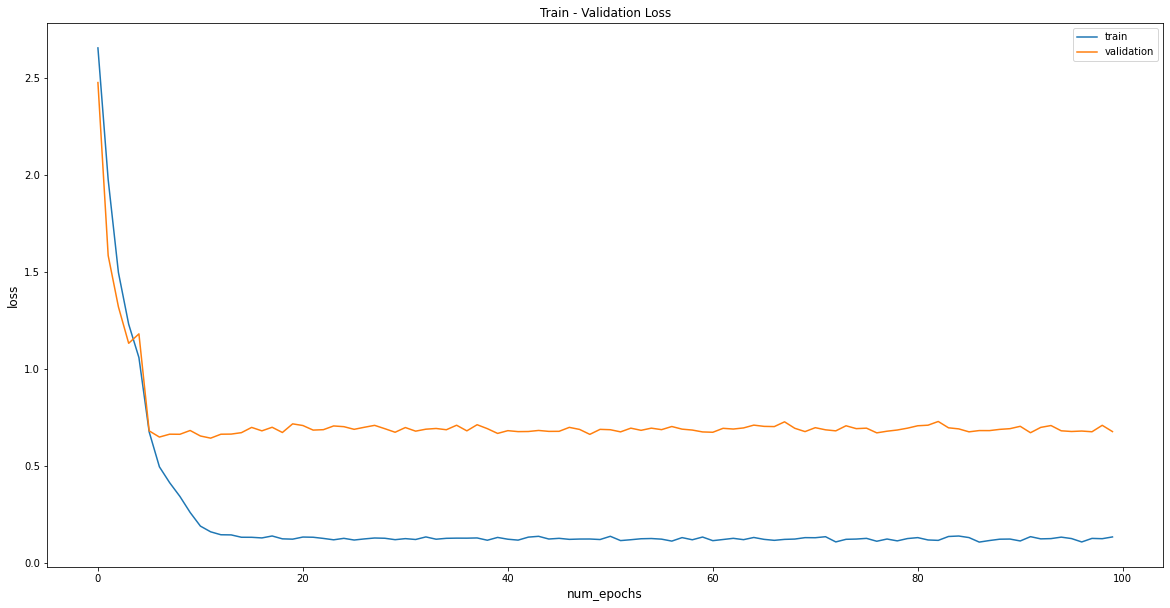

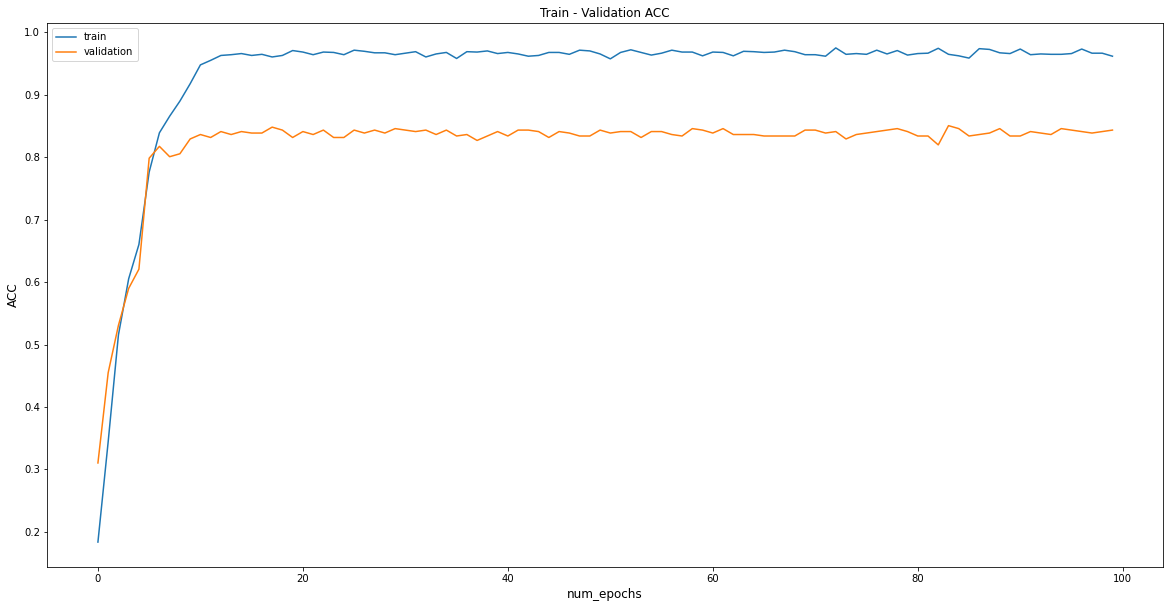

In [24]:
# Dataloaders initialization
base_train_dataloader = torch.utils.data.DataLoader(baseline_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
base_val_dataloader = torch.utils.data.DataLoader(baseline_val_dataset, batch_size=BATCH_SIZE, shuffle=True)

for i in range(3):
    inputs, classes = next(iter(base_train_dataloader))
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

base_dataloaders = {'train': base_train_dataloader, 'val': base_val_dataloader}
base_dataset_sizes = {'train': len(baseline_train_dataset), 'val': len(baseline_val_dataset)}

# Train the model
base_model_ft, base_loss_dict, base_acc_dict = train_model(model_ft, criterion, optimizer_ft, 
                                            exp_lr_scheduler, base_dataloaders, base_dataset_sizes, num_epochs=NUM_EPOCHS)

acc_loss_vis(base_loss_dict, base_acc_dict)

## Split clean data to train and validation

In [65]:
augmented_data_path = 'data'
for class_name in os.listdir('old_data/train'):
    os.makedirs(f'{augmented_data_path}/train/{class_name}', exist_ok=True)
    os.makedirs(f'{augmented_data_path}/val/{class_name}', exist_ok=True)

In [66]:
# move from train to val some of the images and some keep in n
for class_name in os.listdir(f'old_data/train'):
    files_names = os.listdir(f'clean_data/{class_name}')
    random.shuffle(files_names)
    n_images = int(0.2 * (len(files_names) + 1))
    for file_name in files_names[:n_images]:
        shutil.copy(f'clean_data/{class_name}/{file_name}', f'{augmented_data_path}/val/{class_name}/{file_name}')
    for file_name in files_names[n_images:]:
        shutil.copy(f'clean_data/{class_name}/{file_name}', f'{augmented_data_path}/train/{class_name}/{file_name}')

## Clean Data Exploratory


In [67]:
# Paths to clean train and val directories
clean_train_dir = os.path.join("data", "train")
clean_val_dir = os.path.join("data", "val")

In [68]:
# Create a pytorch dataset from a directory of images
clean_train_dataset = datasets.ImageFolder(clean_train_dir, data_transforms)
clean_val_dataset = datasets.ImageFolder(clean_val_dir, data_transforms)

In [29]:
clean_train_len = len(clean_train_dataset)
print(f'The length of the clean train dataset is: {clean_train_len}')
clean_val_len = len(clean_val_dataset)
print(f'The length of the clean validation dataset is: {clean_val_len}')

The length of the clean train dataset is: 1502
The length of the clean validation dataset is: 373


The counts per class for clean train dataset are:
[202, 123, 113, 212, 168, 134, 126, 135, 139, 150]


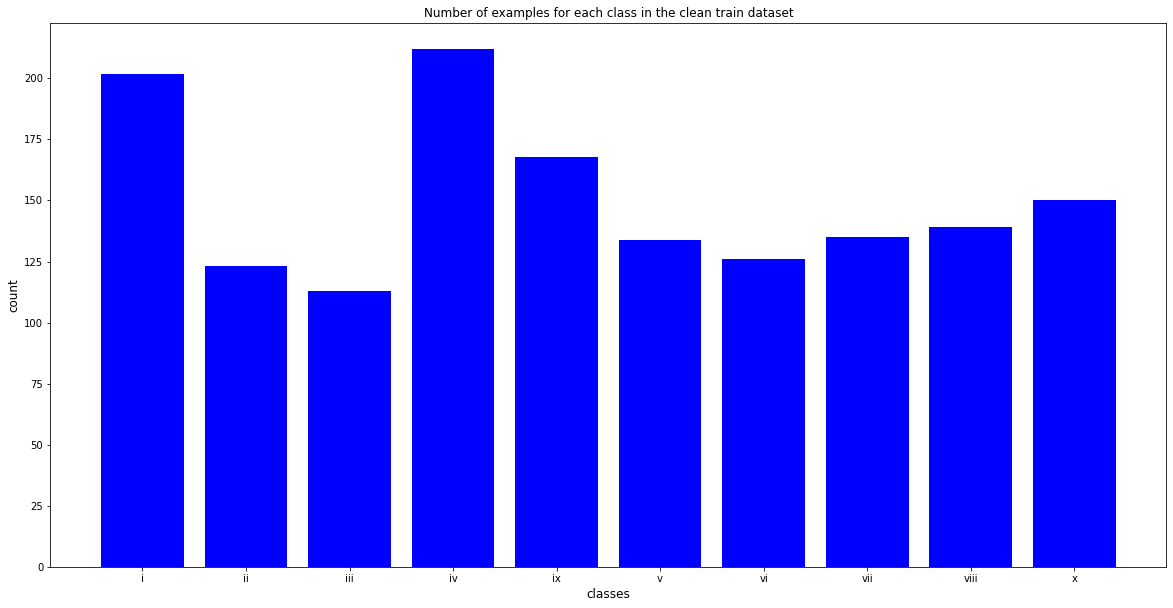

In [31]:
count_and_vis(clean_train_dataset, 'clean train dataset')

The counts per class for clean validation dataset are:
[51, 29, 28, 53, 42, 33, 31, 34, 35, 37]


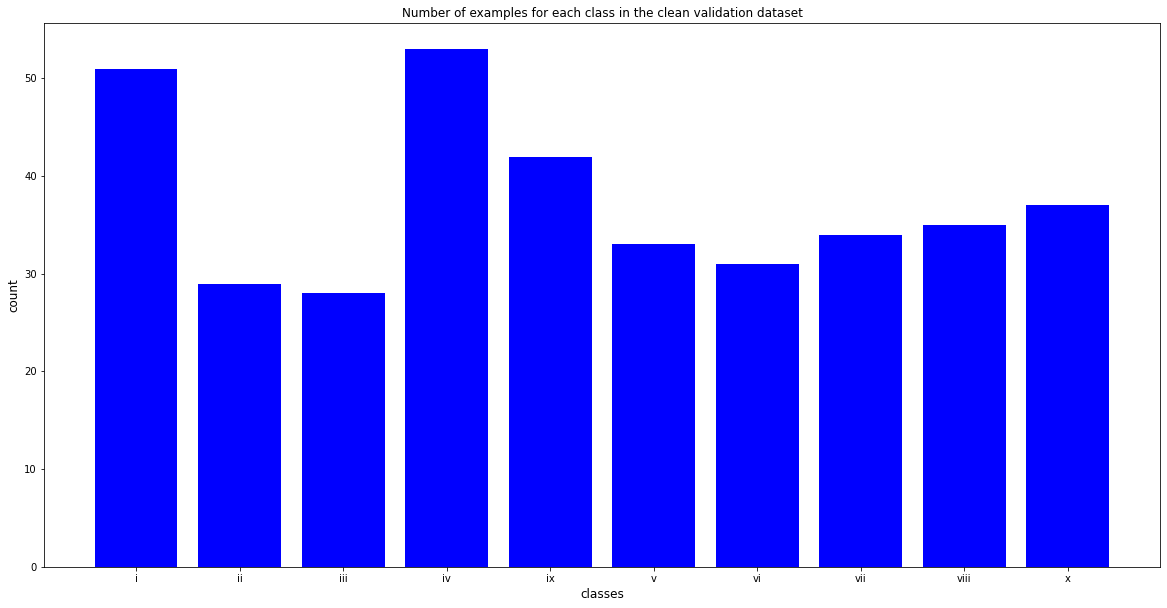

In [32]:
count_and_vis(clean_val_dataset, 'clean validation dataset')

In [33]:
# Use a prebuilt pytorch's ResNet50 model
model_ft = models.resnet50(pretrained=False)

# Fit the last layer for our specific task
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, NUM_CLASSES)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.Adam(model_ft.parameters(), lr=LR)

# Decay LR by a factor of 0.1 every 5 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.1)

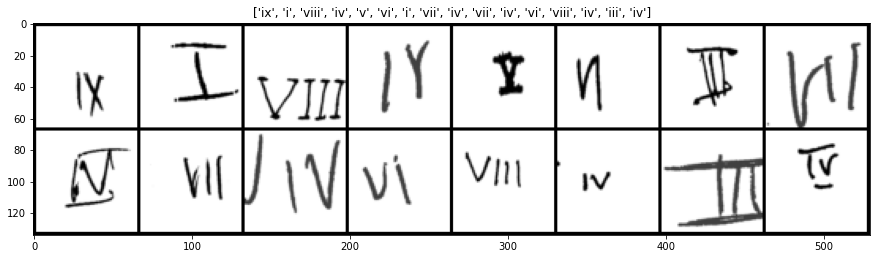

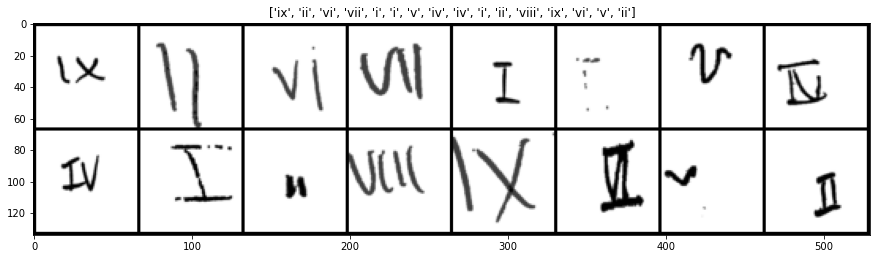

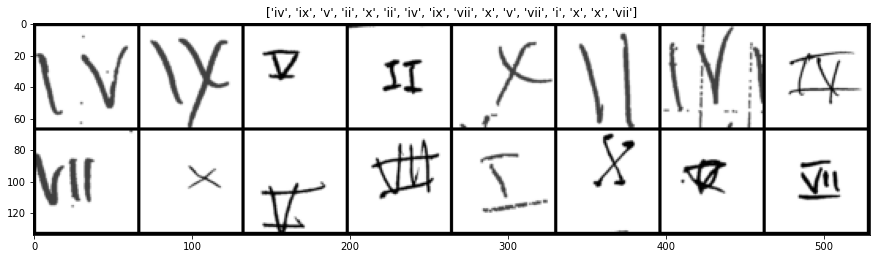

Epoch 1/100
----------


100%|███████████████████████████████████████████| 94/94 [00:07<00:00, 11.86it/s]


train Loss: 2.5289 Acc: 0.1897


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 30.95it/s]


val Loss: 2.3141 Acc: 0.2520

Epoch 2/100
----------


100%|███████████████████████████████████████████| 94/94 [00:07<00:00, 12.23it/s]


train Loss: 1.7544 Acc: 0.4121


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 30.62it/s]


val Loss: 1.2747 Acc: 0.5389

Epoch 3/100
----------


100%|███████████████████████████████████████████| 94/94 [00:07<00:00, 12.25it/s]


train Loss: 1.2162 Acc: 0.5905


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 31.05it/s]


val Loss: 0.9390 Acc: 0.6568

Epoch 4/100
----------


100%|███████████████████████████████████████████| 94/94 [00:07<00:00, 12.28it/s]


train Loss: 0.9185 Acc: 0.6924


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 31.30it/s]


val Loss: 0.6573 Acc: 0.7909

Epoch 5/100
----------


100%|███████████████████████████████████████████| 94/94 [00:07<00:00, 12.22it/s]


train Loss: 0.6676 Acc: 0.7803


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 29.64it/s]


val Loss: 0.7392 Acc: 0.7507

Epoch 6/100
----------


100%|███████████████████████████████████████████| 94/94 [00:07<00:00, 12.07it/s]


train Loss: 0.3565 Acc: 0.8901


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 30.12it/s]


val Loss: 0.3483 Acc: 0.8954

Epoch 7/100
----------


100%|███████████████████████████████████████████| 94/94 [00:07<00:00, 12.15it/s]


train Loss: 0.2548 Acc: 0.9188


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 31.01it/s]


val Loss: 0.3631 Acc: 0.8981

Epoch 8/100
----------


100%|███████████████████████████████████████████| 94/94 [00:07<00:00, 12.30it/s]


train Loss: 0.1852 Acc: 0.9514


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 30.25it/s]


val Loss: 0.3375 Acc: 0.9035

Epoch 9/100
----------


100%|███████████████████████████████████████████| 94/94 [00:07<00:00, 12.12it/s]


train Loss: 0.1775 Acc: 0.9454


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 31.26it/s]


val Loss: 0.3475 Acc: 0.9115

Epoch 10/100
----------


100%|███████████████████████████████████████████| 94/94 [00:07<00:00, 12.35it/s]


train Loss: 0.1255 Acc: 0.9621


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 30.53it/s]


val Loss: 0.3599 Acc: 0.8954

Epoch 11/100
----------


100%|███████████████████████████████████████████| 94/94 [00:07<00:00, 12.27it/s]


train Loss: 0.0743 Acc: 0.9820


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 30.98it/s]


val Loss: 0.3468 Acc: 0.9062

Epoch 12/100
----------


100%|███████████████████████████████████████████| 94/94 [00:07<00:00, 12.36it/s]


train Loss: 0.0799 Acc: 0.9787


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 31.60it/s]


val Loss: 0.3477 Acc: 0.9035

Epoch 13/100
----------


100%|███████████████████████████████████████████| 94/94 [00:07<00:00, 12.20it/s]


train Loss: 0.0692 Acc: 0.9860


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 31.44it/s]


val Loss: 0.3448 Acc: 0.9062

Epoch 14/100
----------


100%|███████████████████████████████████████████| 94/94 [00:07<00:00, 12.34it/s]


train Loss: 0.0685 Acc: 0.9840


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 31.53it/s]


val Loss: 0.3412 Acc: 0.9088

Epoch 15/100
----------


100%|███████████████████████████████████████████| 94/94 [00:07<00:00, 12.20it/s]


train Loss: 0.0660 Acc: 0.9880


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 29.96it/s]


val Loss: 0.3452 Acc: 0.9035

Epoch 16/100
----------


100%|███████████████████████████████████████████| 94/94 [00:07<00:00, 11.86it/s]


train Loss: 0.0727 Acc: 0.9800


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 29.41it/s]


val Loss: 0.3409 Acc: 0.9035

Epoch 17/100
----------


100%|███████████████████████████████████████████| 94/94 [00:07<00:00, 12.39it/s]


train Loss: 0.0682 Acc: 0.9820


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 31.27it/s]


val Loss: 0.3607 Acc: 0.9008

Epoch 18/100
----------


100%|███████████████████████████████████████████| 94/94 [00:07<00:00, 12.39it/s]


train Loss: 0.0698 Acc: 0.9847


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 30.43it/s]


val Loss: 0.3406 Acc: 0.9035

Epoch 19/100
----------


100%|███████████████████████████████████████████| 94/94 [00:07<00:00, 12.37it/s]


train Loss: 0.0546 Acc: 0.9880


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 30.72it/s]


val Loss: 0.3331 Acc: 0.9062

Epoch 20/100
----------


100%|███████████████████████████████████████████| 94/94 [00:07<00:00, 12.24it/s]


train Loss: 0.0573 Acc: 0.9847


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 31.15it/s]


val Loss: 0.3465 Acc: 0.9035

Epoch 21/100
----------


100%|███████████████████████████████████████████| 94/94 [00:07<00:00, 12.17it/s]


train Loss: 0.0648 Acc: 0.9820


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 31.09it/s]


val Loss: 0.3457 Acc: 0.9008

Epoch 22/100
----------


100%|███████████████████████████████████████████| 94/94 [00:07<00:00, 12.34it/s]


train Loss: 0.0739 Acc: 0.9820


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 30.52it/s]


val Loss: 0.3423 Acc: 0.9035

Epoch 23/100
----------


100%|███████████████████████████████████████████| 94/94 [00:07<00:00, 12.25it/s]


train Loss: 0.0730 Acc: 0.9820


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 31.48it/s]


val Loss: 0.3521 Acc: 0.9008

Epoch 24/100
----------


100%|███████████████████████████████████████████| 94/94 [00:07<00:00, 12.20it/s]


train Loss: 0.0770 Acc: 0.9814


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 31.53it/s]


val Loss: 0.3437 Acc: 0.9062

Epoch 25/100
----------


100%|███████████████████████████████████████████| 94/94 [00:07<00:00, 12.35it/s]


train Loss: 0.0615 Acc: 0.9860


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 30.37it/s]


val Loss: 0.3485 Acc: 0.9008

Epoch 26/100
----------


100%|███████████████████████████████████████████| 94/94 [00:07<00:00, 12.30it/s]


train Loss: 0.0626 Acc: 0.9840


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 31.26it/s]


val Loss: 0.3590 Acc: 0.8981

Epoch 27/100
----------


100%|███████████████████████████████████████████| 94/94 [00:07<00:00, 12.26it/s]


train Loss: 0.0588 Acc: 0.9893


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 31.36it/s]


val Loss: 0.3513 Acc: 0.9008

Epoch 28/100
----------


100%|███████████████████████████████████████████| 94/94 [00:07<00:00, 12.06it/s]


train Loss: 0.0583 Acc: 0.9887


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 30.99it/s]


val Loss: 0.3499 Acc: 0.9088

Epoch 29/100
----------


100%|███████████████████████████████████████████| 94/94 [00:07<00:00, 12.34it/s]


train Loss: 0.0562 Acc: 0.9887


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 31.36it/s]


val Loss: 0.3377 Acc: 0.9062

Epoch 30/100
----------


100%|███████████████████████████████████████████| 94/94 [00:07<00:00, 12.35it/s]


train Loss: 0.0669 Acc: 0.9860


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 30.84it/s]


val Loss: 0.3429 Acc: 0.9062

Epoch 31/100
----------


100%|███████████████████████████████████████████| 94/94 [00:07<00:00, 12.43it/s]


train Loss: 0.0722 Acc: 0.9827


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 31.31it/s]


val Loss: 0.3448 Acc: 0.9088

Epoch 32/100
----------


100%|███████████████████████████████████████████| 94/94 [00:07<00:00, 12.38it/s]


train Loss: 0.0617 Acc: 0.9860


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 30.83it/s]


val Loss: 0.3433 Acc: 0.9062

Epoch 33/100
----------


100%|███████████████████████████████████████████| 94/94 [00:07<00:00, 12.07it/s]


train Loss: 0.0590 Acc: 0.9860


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 30.98it/s]


val Loss: 0.3521 Acc: 0.9008

Epoch 34/100
----------


100%|███████████████████████████████████████████| 94/94 [00:07<00:00, 12.37it/s]


train Loss: 0.0621 Acc: 0.9860


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 30.19it/s]


val Loss: 0.3585 Acc: 0.8954

Epoch 35/100
----------


100%|███████████████████████████████████████████| 94/94 [00:07<00:00, 12.35it/s]


train Loss: 0.0676 Acc: 0.9827


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 30.93it/s]


val Loss: 0.3526 Acc: 0.9008

Epoch 36/100
----------


100%|███████████████████████████████████████████| 94/94 [00:07<00:00, 12.30it/s]


train Loss: 0.0558 Acc: 0.9900


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 30.82it/s]


val Loss: 0.3484 Acc: 0.9035

Epoch 37/100
----------


100%|███████████████████████████████████████████| 94/94 [00:07<00:00, 12.29it/s]


train Loss: 0.0688 Acc: 0.9814


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 31.12it/s]


val Loss: 0.3428 Acc: 0.9062

Epoch 38/100
----------


100%|███████████████████████████████████████████| 94/94 [00:07<00:00, 12.39it/s]


train Loss: 0.0582 Acc: 0.9893


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 31.26it/s]


val Loss: 0.3471 Acc: 0.9008

Epoch 39/100
----------


100%|███████████████████████████████████████████| 94/94 [00:07<00:00, 12.32it/s]


train Loss: 0.0632 Acc: 0.9860


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 31.23it/s]


val Loss: 0.3367 Acc: 0.9088

Epoch 40/100
----------


100%|███████████████████████████████████████████| 94/94 [00:07<00:00, 12.22it/s]


train Loss: 0.0575 Acc: 0.9874


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 30.43it/s]


val Loss: 0.3357 Acc: 0.9035

Epoch 41/100
----------


100%|███████████████████████████████████████████| 94/94 [00:07<00:00, 12.21it/s]


train Loss: 0.0636 Acc: 0.9867


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 30.92it/s]


val Loss: 0.3515 Acc: 0.9035

Epoch 42/100
----------


100%|███████████████████████████████████████████| 94/94 [00:07<00:00, 12.28it/s]


train Loss: 0.0611 Acc: 0.9847


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 31.18it/s]


val Loss: 0.3443 Acc: 0.9035

Epoch 43/100
----------


100%|███████████████████████████████████████████| 94/94 [00:07<00:00, 12.13it/s]


train Loss: 0.0567 Acc: 0.9867


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 31.21it/s]


val Loss: 0.3442 Acc: 0.9008

Epoch 44/100
----------


100%|███████████████████████████████████████████| 94/94 [00:07<00:00, 12.28it/s]


train Loss: 0.0618 Acc: 0.9874


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 31.24it/s]


val Loss: 0.3498 Acc: 0.8981

Epoch 45/100
----------


100%|███████████████████████████████████████████| 94/94 [00:07<00:00, 12.40it/s]


train Loss: 0.0606 Acc: 0.9860


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 31.40it/s]


val Loss: 0.3476 Acc: 0.8981

Epoch 46/100
----------


100%|███████████████████████████████████████████| 94/94 [00:07<00:00, 12.39it/s]


train Loss: 0.0726 Acc: 0.9807


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 31.06it/s]


val Loss: 0.3494 Acc: 0.9035

Epoch 47/100
----------


100%|███████████████████████████████████████████| 94/94 [00:07<00:00, 12.13it/s]


train Loss: 0.0600 Acc: 0.9860


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 28.90it/s]


val Loss: 0.3505 Acc: 0.9008

Epoch 48/100
----------


100%|███████████████████████████████████████████| 94/94 [00:07<00:00, 12.09it/s]


train Loss: 0.0554 Acc: 0.9874


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 29.03it/s]


val Loss: 0.3434 Acc: 0.9088

Epoch 49/100
----------


100%|███████████████████████████████████████████| 94/94 [00:07<00:00, 11.88it/s]


train Loss: 0.0632 Acc: 0.9834


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 28.98it/s]


val Loss: 0.3470 Acc: 0.8981

Epoch 50/100
----------


100%|███████████████████████████████████████████| 94/94 [00:07<00:00, 11.91it/s]


train Loss: 0.0563 Acc: 0.9880


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 31.04it/s]


val Loss: 0.3409 Acc: 0.9088

Epoch 51/100
----------


100%|███████████████████████████████████████████| 94/94 [00:07<00:00, 12.19it/s]


train Loss: 0.0520 Acc: 0.9893


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 30.90it/s]


val Loss: 0.3419 Acc: 0.9008

Epoch 52/100
----------


100%|███████████████████████████████████████████| 94/94 [00:07<00:00, 12.13it/s]


train Loss: 0.0804 Acc: 0.9747


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 30.39it/s]


val Loss: 0.3582 Acc: 0.8954

Epoch 53/100
----------


100%|███████████████████████████████████████████| 94/94 [00:07<00:00, 12.25it/s]


train Loss: 0.0629 Acc: 0.9827


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 30.50it/s]


val Loss: 0.3415 Acc: 0.9035

Epoch 54/100
----------


100%|███████████████████████████████████████████| 94/94 [00:07<00:00, 12.27it/s]


train Loss: 0.0520 Acc: 0.9900


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 30.94it/s]


val Loss: 0.3434 Acc: 0.9062

Epoch 55/100
----------


100%|███████████████████████████████████████████| 94/94 [00:07<00:00, 12.32it/s]


train Loss: 0.0735 Acc: 0.9820


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 30.37it/s]


val Loss: 0.3432 Acc: 0.9062

Epoch 56/100
----------


100%|███████████████████████████████████████████| 94/94 [00:07<00:00, 12.20it/s]


train Loss: 0.0542 Acc: 0.9907


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 30.94it/s]


val Loss: 0.3540 Acc: 0.9008

Epoch 57/100
----------


100%|███████████████████████████████████████████| 94/94 [00:07<00:00, 12.32it/s]


train Loss: 0.0563 Acc: 0.9893


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 31.35it/s]


val Loss: 0.3466 Acc: 0.9035

Epoch 58/100
----------


100%|███████████████████████████████████████████| 94/94 [00:07<00:00, 12.35it/s]


train Loss: 0.0607 Acc: 0.9827


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 30.96it/s]


val Loss: 0.3483 Acc: 0.9062

Epoch 59/100
----------


100%|███████████████████████████████████████████| 94/94 [00:07<00:00, 12.30it/s]


train Loss: 0.0699 Acc: 0.9807


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 30.61it/s]


val Loss: 0.3434 Acc: 0.9088

Epoch 60/100
----------


100%|███████████████████████████████████████████| 94/94 [00:07<00:00, 12.03it/s]


train Loss: 0.0729 Acc: 0.9800


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 30.99it/s]


val Loss: 0.3546 Acc: 0.8954

Epoch 61/100
----------


100%|███████████████████████████████████████████| 94/94 [00:07<00:00, 12.28it/s]


train Loss: 0.0665 Acc: 0.9814


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 31.30it/s]


val Loss: 0.3509 Acc: 0.9062

Epoch 62/100
----------


100%|███████████████████████████████████████████| 94/94 [00:07<00:00, 12.34it/s]


train Loss: 0.0745 Acc: 0.9854


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 29.92it/s]


val Loss: 0.3359 Acc: 0.9062

Epoch 63/100
----------


100%|███████████████████████████████████████████| 94/94 [00:07<00:00, 11.90it/s]


train Loss: 0.0566 Acc: 0.9880


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 28.03it/s]


val Loss: 0.3459 Acc: 0.9035

Epoch 64/100
----------


100%|███████████████████████████████████████████| 94/94 [00:07<00:00, 12.29it/s]


train Loss: 0.0607 Acc: 0.9893


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 31.66it/s]


val Loss: 0.3434 Acc: 0.9008

Epoch 65/100
----------


100%|███████████████████████████████████████████| 94/94 [00:07<00:00, 12.33it/s]


train Loss: 0.0565 Acc: 0.9893


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 31.08it/s]


val Loss: 0.3444 Acc: 0.9088

Epoch 66/100
----------


100%|███████████████████████████████████████████| 94/94 [00:07<00:00, 12.38it/s]


train Loss: 0.0632 Acc: 0.9840


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 31.40it/s]


val Loss: 0.3447 Acc: 0.9008

Epoch 67/100
----------


100%|███████████████████████████████████████████| 94/94 [00:07<00:00, 12.44it/s]


train Loss: 0.0599 Acc: 0.9874


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 30.89it/s]


val Loss: 0.3381 Acc: 0.9062

Epoch 68/100
----------


100%|███████████████████████████████████████████| 94/94 [00:07<00:00, 12.37it/s]


train Loss: 0.0698 Acc: 0.9780


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 31.45it/s]


val Loss: 0.3446 Acc: 0.9008

Epoch 69/100
----------


100%|███████████████████████████████████████████| 94/94 [00:07<00:00, 12.29it/s]


train Loss: 0.0618 Acc: 0.9840


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 29.29it/s]


val Loss: 0.3410 Acc: 0.9062

Epoch 70/100
----------


100%|███████████████████████████████████████████| 94/94 [00:07<00:00, 12.21it/s]


train Loss: 0.0731 Acc: 0.9807


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 31.20it/s]


val Loss: 0.3386 Acc: 0.9062

Epoch 71/100
----------


100%|███████████████████████████████████████████| 94/94 [00:07<00:00, 12.42it/s]


train Loss: 0.0708 Acc: 0.9800


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 31.16it/s]


val Loss: 0.3437 Acc: 0.9062

Epoch 72/100
----------


100%|███████████████████████████████████████████| 94/94 [00:07<00:00, 12.09it/s]


train Loss: 0.0675 Acc: 0.9814


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 30.52it/s]


val Loss: 0.3430 Acc: 0.9062

Epoch 73/100
----------


100%|███████████████████████████████████████████| 94/94 [00:07<00:00, 12.03it/s]


train Loss: 0.0566 Acc: 0.9840


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 30.46it/s]


val Loss: 0.3378 Acc: 0.9062

Epoch 74/100
----------


100%|███████████████████████████████████████████| 94/94 [00:07<00:00, 12.33it/s]


train Loss: 0.0771 Acc: 0.9794


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 31.57it/s]


val Loss: 0.3468 Acc: 0.9062

Epoch 75/100
----------


100%|███████████████████████████████████████████| 94/94 [00:07<00:00, 12.31it/s]


train Loss: 0.0581 Acc: 0.9887


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 31.58it/s]


val Loss: 0.3390 Acc: 0.9035

Epoch 76/100
----------


100%|███████████████████████████████████████████| 94/94 [00:07<00:00, 12.42it/s]


train Loss: 0.0630 Acc: 0.9827


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 31.68it/s]


val Loss: 0.3397 Acc: 0.9088

Epoch 77/100
----------


100%|███████████████████████████████████████████| 94/94 [00:07<00:00, 12.35it/s]


train Loss: 0.0506 Acc: 0.9933


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 30.87it/s]


val Loss: 0.3454 Acc: 0.9062

Epoch 78/100
----------


100%|███████████████████████████████████████████| 94/94 [00:07<00:00, 12.00it/s]


train Loss: 0.0617 Acc: 0.9847


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 30.43it/s]


val Loss: 0.3454 Acc: 0.9008

Epoch 79/100
----------


100%|███████████████████████████████████████████| 94/94 [00:07<00:00, 12.37it/s]


train Loss: 0.0564 Acc: 0.9847


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 31.38it/s]


val Loss: 0.3471 Acc: 0.9035

Epoch 80/100
----------


100%|███████████████████████████████████████████| 94/94 [00:07<00:00, 12.27it/s]


train Loss: 0.0679 Acc: 0.9854


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 30.95it/s]


val Loss: 0.3478 Acc: 0.9035

Epoch 81/100
----------


100%|███████████████████████████████████████████| 94/94 [00:07<00:00, 12.31it/s]


train Loss: 0.0627 Acc: 0.9834


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 30.65it/s]


val Loss: 0.3442 Acc: 0.9008

Epoch 82/100
----------


100%|███████████████████████████████████████████| 94/94 [00:07<00:00, 12.36it/s]


train Loss: 0.0672 Acc: 0.9854


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 31.47it/s]


val Loss: 0.3457 Acc: 0.9035

Epoch 83/100
----------


100%|███████████████████████████████████████████| 94/94 [00:07<00:00, 12.36it/s]


train Loss: 0.0562 Acc: 0.9847


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 31.01it/s]


val Loss: 0.3505 Acc: 0.9008

Epoch 84/100
----------


100%|███████████████████████████████████████████| 94/94 [00:07<00:00, 11.90it/s]


train Loss: 0.0676 Acc: 0.9854


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 31.35it/s]


val Loss: 0.3415 Acc: 0.9035

Epoch 85/100
----------


100%|███████████████████████████████████████████| 94/94 [00:07<00:00, 12.22it/s]


train Loss: 0.0662 Acc: 0.9847


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 30.22it/s]


val Loss: 0.3448 Acc: 0.9088

Epoch 86/100
----------


100%|███████████████████████████████████████████| 94/94 [00:07<00:00, 12.08it/s]


train Loss: 0.0583 Acc: 0.9867


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 29.89it/s]


val Loss: 0.3453 Acc: 0.9062

Epoch 87/100
----------


100%|███████████████████████████████████████████| 94/94 [00:07<00:00, 12.25it/s]


train Loss: 0.0572 Acc: 0.9880


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 31.43it/s]


val Loss: 0.3519 Acc: 0.8954

Epoch 88/100
----------


100%|███████████████████████████████████████████| 94/94 [00:07<00:00, 12.40it/s]


train Loss: 0.0513 Acc: 0.9920


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 31.61it/s]


val Loss: 0.3447 Acc: 0.9035

Epoch 89/100
----------


100%|███████████████████████████████████████████| 94/94 [00:07<00:00, 12.41it/s]


train Loss: 0.0669 Acc: 0.9834


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 31.58it/s]


val Loss: 0.3475 Acc: 0.9008

Epoch 90/100
----------


100%|███████████████████████████████████████████| 94/94 [00:07<00:00, 12.34it/s]


train Loss: 0.0655 Acc: 0.9840


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 30.82it/s]


val Loss: 0.3403 Acc: 0.9062

Epoch 91/100
----------


100%|███████████████████████████████████████████| 94/94 [00:07<00:00, 12.15it/s]


train Loss: 0.0528 Acc: 0.9907


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 30.71it/s]


val Loss: 0.3482 Acc: 0.9062

Epoch 92/100
----------


100%|███████████████████████████████████████████| 94/94 [00:07<00:00, 12.41it/s]


train Loss: 0.0529 Acc: 0.9913


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 31.42it/s]


val Loss: 0.3494 Acc: 0.9008

Epoch 93/100
----------


100%|███████████████████████████████████████████| 94/94 [00:07<00:00, 12.36it/s]


train Loss: 0.0639 Acc: 0.9867


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 31.02it/s]


val Loss: 0.3483 Acc: 0.9008

Epoch 94/100
----------


100%|███████████████████████████████████████████| 94/94 [00:07<00:00, 12.28it/s]


train Loss: 0.0580 Acc: 0.9874


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 31.12it/s]


val Loss: 0.3492 Acc: 0.9008

Epoch 95/100
----------


100%|███████████████████████████████████████████| 94/94 [00:07<00:00, 12.02it/s]


train Loss: 0.0545 Acc: 0.9874


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 30.99it/s]


val Loss: 0.3557 Acc: 0.8981

Epoch 96/100
----------


100%|███████████████████████████████████████████| 94/94 [00:07<00:00, 12.32it/s]


train Loss: 0.0626 Acc: 0.9874


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 31.10it/s]


val Loss: 0.3461 Acc: 0.9062

Epoch 97/100
----------


100%|███████████████████████████████████████████| 94/94 [00:07<00:00, 12.41it/s]


train Loss: 0.0582 Acc: 0.9854


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 31.59it/s]


val Loss: 0.3429 Acc: 0.9062

Epoch 98/100
----------


100%|███████████████████████████████████████████| 94/94 [00:07<00:00, 12.34it/s]


train Loss: 0.0580 Acc: 0.9854


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 30.40it/s]


val Loss: 0.3514 Acc: 0.9008

Epoch 99/100
----------


100%|███████████████████████████████████████████| 94/94 [00:07<00:00, 12.33it/s]


train Loss: 0.0658 Acc: 0.9860


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 31.20it/s]


val Loss: 0.3467 Acc: 0.9008

Epoch 100/100
----------


100%|███████████████████████████████████████████| 94/94 [00:07<00:00, 12.35it/s]


train Loss: 0.0690 Acc: 0.9840


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 31.05it/s]


val Loss: 0.3501 Acc: 0.9035

Training complete in 14m 6s
Best val Acc: 0.911528


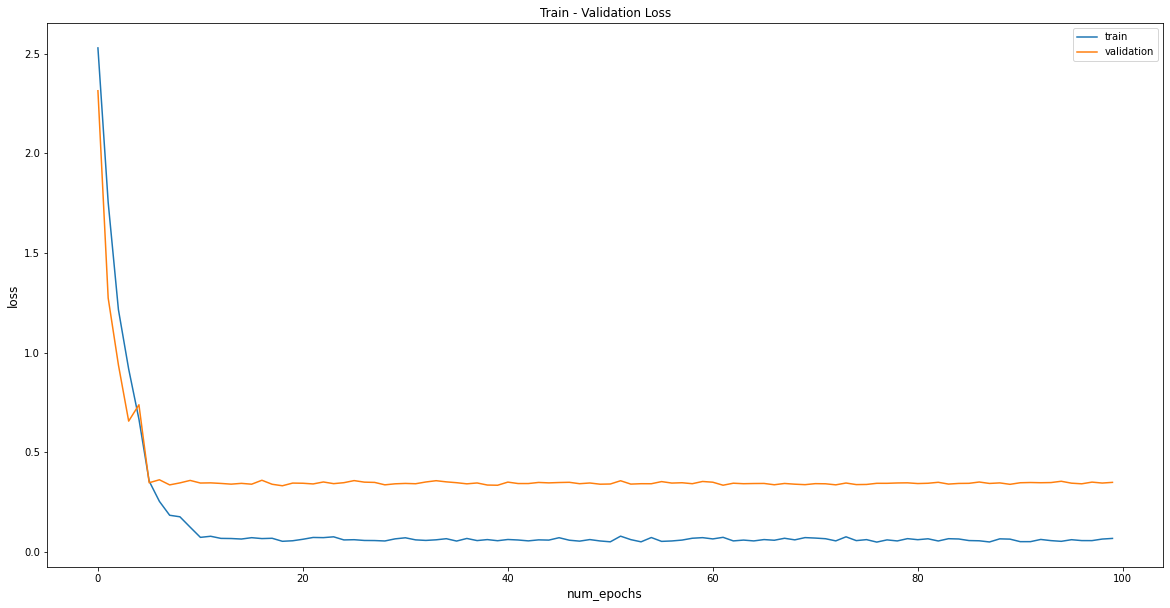

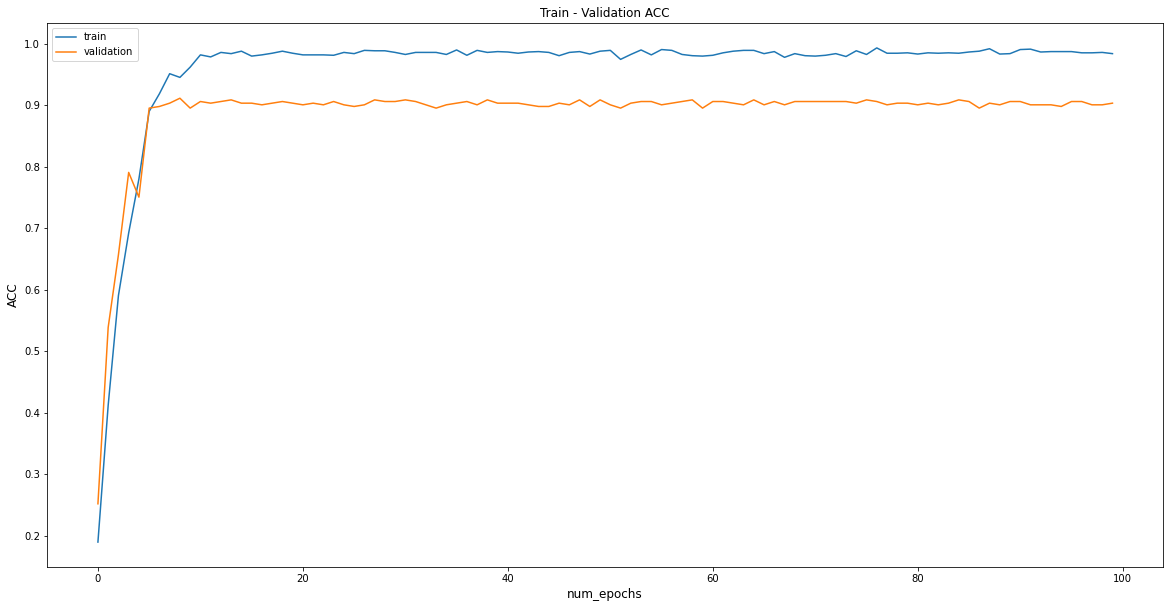

In [34]:
# Dataloaders initialization
clean_train_dataloader = torch.utils.data.DataLoader(clean_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
clean_val_dataloader = torch.utils.data.DataLoader(clean_val_dataset, batch_size=BATCH_SIZE, shuffle=True)

for i in range(3):
    inputs, classes = next(iter(clean_train_dataloader))
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

clean_dataloaders = {'train': clean_train_dataloader, 'val': clean_val_dataloader}
clean_dataset_sizes = {'train': len(clean_train_dataset), 'val': len(clean_val_dataset)}

# Train the model
clean_model_ft, clean_loss_dict, clean_acc_dict = train_model(model_ft, criterion, optimizer_ft, 
                                            exp_lr_scheduler, clean_dataloaders, clean_dataset_sizes, num_epochs=NUM_EPOCHS)

acc_loss_vis(clean_loss_dict, clean_acc_dict)

## Data Normalization

In [35]:
train_loader = DataLoader(clean_train_dataset, BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)

train_mean = 0.
train_std = 0.
for images, _ in train_loader:
    batch_samples = images.size(0) # batch size (the last batch can have smaller size!)
    images = images.view(batch_samples, images.size(1), -1)

    train_mean += images.mean(2).sum(0)
    train_std += images.std(2).sum(0)

train_mean /= len(train_loader.dataset)
train_std /= len(train_loader.dataset)

print('Mean: ', train_mean[0])
print('Std: ', train_std[0])

Mean:  tensor(0.9454)
Std:  tensor(0.1801)


In [36]:
data_normalization = transforms.Compose([transforms.Resize([64, 64]), transforms.ToTensor(), transforms.Normalize((train_mean[0],), (train_std[0],))])

In [37]:
# Create a pytorch dataset from a directory of images
norm_train_dataset = datasets.ImageFolder(clean_train_dir, data_normalization)
norm_val_dataset = datasets.ImageFolder(clean_val_dir, data_normalization)

In [38]:
# Use a prebuilt pytorch's ResNet50 model
model_ft = models.resnet50(pretrained=False)

# Fit the last layer for our specific task
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, NUM_CLASSES)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.Adam(model_ft.parameters(), lr=LR)

# Decay LR by a factor of 0.1 every 5 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


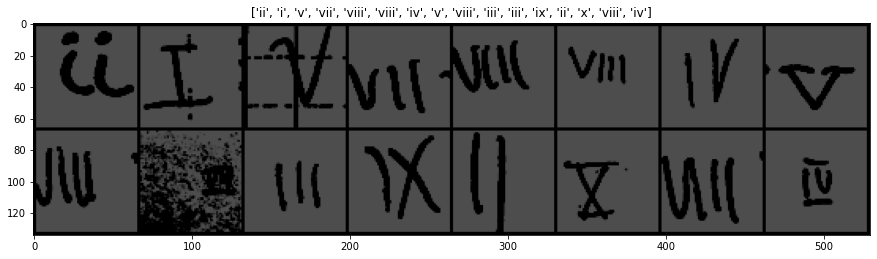

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


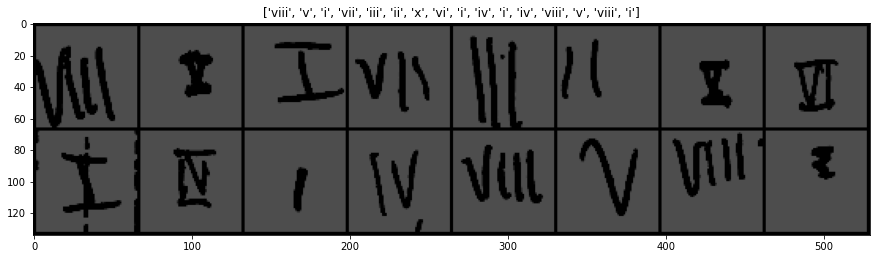

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


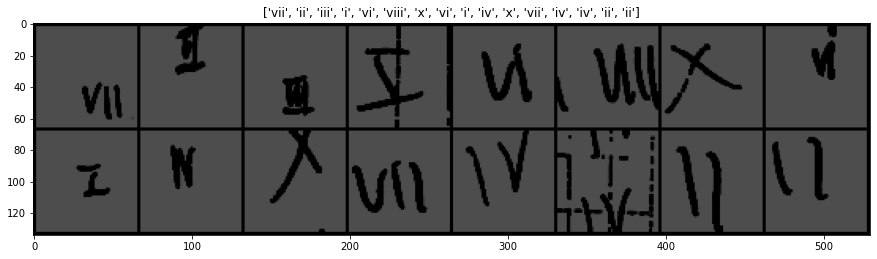

Epoch 1/100
----------


100%|███████████████████████████████████████████| 94/94 [00:07<00:00, 11.82it/s]


train Loss: 2.5192 Acc: 0.2217


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 28.15it/s]


val Loss: 1.8129 Acc: 0.3887

Epoch 2/100
----------


100%|███████████████████████████████████████████| 94/94 [00:08<00:00, 11.55it/s]


train Loss: 1.5301 Acc: 0.4933


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 27.64it/s]


val Loss: 1.1144 Acc: 0.6139

Epoch 3/100
----------


100%|███████████████████████████████████████████| 94/94 [00:08<00:00, 11.68it/s]


train Loss: 1.0014 Acc: 0.6711


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 26.93it/s]


val Loss: 0.8686 Acc: 0.7078

Epoch 4/100
----------


100%|███████████████████████████████████████████| 94/94 [00:08<00:00, 11.43it/s]


train Loss: 0.8753 Acc: 0.7204


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 26.40it/s]


val Loss: 1.0611 Acc: 0.6917

Epoch 5/100
----------


100%|███████████████████████████████████████████| 94/94 [00:08<00:00, 11.61it/s]


train Loss: 0.6954 Acc: 0.7617


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 28.09it/s]


val Loss: 0.5920 Acc: 0.8311

Epoch 6/100
----------


100%|███████████████████████████████████████████| 94/94 [00:07<00:00, 11.80it/s]


train Loss: 0.3964 Acc: 0.8748


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 27.86it/s]


val Loss: 0.3700 Acc: 0.8901

Epoch 7/100
----------


100%|███████████████████████████████████████████| 94/94 [00:07<00:00, 11.78it/s]


train Loss: 0.2515 Acc: 0.9288


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 28.01it/s]


val Loss: 0.3539 Acc: 0.8928

Epoch 8/100
----------


100%|███████████████████████████████████████████| 94/94 [00:07<00:00, 11.84it/s]


train Loss: 0.2035 Acc: 0.9421


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 27.74it/s]


val Loss: 0.3910 Acc: 0.8954

Epoch 9/100
----------


100%|███████████████████████████████████████████| 94/94 [00:07<00:00, 11.84it/s]


train Loss: 0.1687 Acc: 0.9541


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 28.35it/s]


val Loss: 0.3675 Acc: 0.9088

Epoch 10/100
----------


100%|███████████████████████████████████████████| 94/94 [00:08<00:00, 11.69it/s]


train Loss: 0.1234 Acc: 0.9634


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 27.79it/s]


val Loss: 0.3719 Acc: 0.9062

Epoch 11/100
----------


100%|███████████████████████████████████████████| 94/94 [00:07<00:00, 11.77it/s]


train Loss: 0.0938 Acc: 0.9800


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 26.12it/s]


val Loss: 0.3754 Acc: 0.9008

Epoch 12/100
----------


100%|███████████████████████████████████████████| 94/94 [00:08<00:00, 11.43it/s]


train Loss: 0.0979 Acc: 0.9734


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 26.68it/s]


val Loss: 0.3719 Acc: 0.9115

Epoch 13/100
----------


100%|███████████████████████████████████████████| 94/94 [00:08<00:00, 11.60it/s]


train Loss: 0.0867 Acc: 0.9754


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 28.11it/s]


val Loss: 0.3734 Acc: 0.9142

Epoch 14/100
----------


100%|███████████████████████████████████████████| 94/94 [00:07<00:00, 11.82it/s]


train Loss: 0.0876 Acc: 0.9767


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 28.33it/s]


val Loss: 0.3815 Acc: 0.9088

Epoch 15/100
----------


100%|███████████████████████████████████████████| 94/94 [00:07<00:00, 11.78it/s]


train Loss: 0.0816 Acc: 0.9780


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 27.95it/s]


val Loss: 0.3784 Acc: 0.9088

Epoch 16/100
----------


100%|███████████████████████████████████████████| 94/94 [00:07<00:00, 11.76it/s]


train Loss: 0.0755 Acc: 0.9800


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 27.49it/s]


val Loss: 0.3875 Acc: 0.9008

Epoch 17/100
----------


100%|███████████████████████████████████████████| 94/94 [00:08<00:00, 11.74it/s]


train Loss: 0.0785 Acc: 0.9827


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 27.55it/s]


val Loss: 0.3864 Acc: 0.9062

Epoch 18/100
----------


100%|███████████████████████████████████████████| 94/94 [00:07<00:00, 11.78it/s]


train Loss: 0.0771 Acc: 0.9787


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 27.76it/s]


val Loss: 0.3820 Acc: 0.9062

Epoch 19/100
----------


100%|███████████████████████████████████████████| 94/94 [00:07<00:00, 11.83it/s]


train Loss: 0.0822 Acc: 0.9787


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 27.83it/s]


val Loss: 0.3848 Acc: 0.9088

Epoch 20/100
----------


100%|███████████████████████████████████████████| 94/94 [00:07<00:00, 11.76it/s]


train Loss: 0.0662 Acc: 0.9827


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 27.51it/s]


val Loss: 0.3938 Acc: 0.9062

Epoch 21/100
----------


100%|███████████████████████████████████████████| 94/94 [00:08<00:00, 11.70it/s]


train Loss: 0.0736 Acc: 0.9787


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 28.17it/s]


val Loss: 0.3791 Acc: 0.9035

Epoch 22/100
----------


100%|███████████████████████████████████████████| 94/94 [00:08<00:00, 11.70it/s]


train Loss: 0.0780 Acc: 0.9807


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 26.19it/s]


val Loss: 0.3877 Acc: 0.9115

Epoch 23/100
----------


100%|███████████████████████████████████████████| 94/94 [00:08<00:00, 11.64it/s]


train Loss: 0.0722 Acc: 0.9807


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 28.37it/s]


val Loss: 0.3857 Acc: 0.9035

Epoch 24/100
----------


100%|███████████████████████████████████████████| 94/94 [00:07<00:00, 11.84it/s]


train Loss: 0.0803 Acc: 0.9787


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 27.98it/s]


val Loss: 0.3912 Acc: 0.9142

Epoch 25/100
----------


100%|███████████████████████████████████████████| 94/94 [00:08<00:00, 11.65it/s]


train Loss: 0.0760 Acc: 0.9814


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 26.70it/s]


val Loss: 0.3827 Acc: 0.9088

Epoch 26/100
----------


100%|███████████████████████████████████████████| 94/94 [00:08<00:00, 11.39it/s]


train Loss: 0.0976 Acc: 0.9740


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 28.32it/s]


val Loss: 0.3947 Acc: 0.9035

Epoch 27/100
----------


100%|███████████████████████████████████████████| 94/94 [00:08<00:00, 11.69it/s]


train Loss: 0.0773 Acc: 0.9800


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 27.30it/s]


val Loss: 0.3810 Acc: 0.9169

Epoch 28/100
----------


100%|███████████████████████████████████████████| 94/94 [00:07<00:00, 11.76it/s]


train Loss: 0.0770 Acc: 0.9774


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 28.21it/s]


val Loss: 0.3891 Acc: 0.9088

Epoch 29/100
----------


100%|███████████████████████████████████████████| 94/94 [00:08<00:00, 11.41it/s]


train Loss: 0.0683 Acc: 0.9820


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 27.42it/s]


val Loss: 0.3858 Acc: 0.9142

Epoch 30/100
----------


100%|███████████████████████████████████████████| 94/94 [00:08<00:00, 11.62it/s]


train Loss: 0.0882 Acc: 0.9754


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 27.58it/s]


val Loss: 0.3792 Acc: 0.9088

Epoch 31/100
----------


100%|███████████████████████████████████████████| 94/94 [00:07<00:00, 11.85it/s]


train Loss: 0.0688 Acc: 0.9834


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 28.58it/s]


val Loss: 0.3808 Acc: 0.9115

Epoch 32/100
----------


100%|███████████████████████████████████████████| 94/94 [00:08<00:00, 11.75it/s]


train Loss: 0.0667 Acc: 0.9874


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 28.45it/s]


val Loss: 0.3959 Acc: 0.9115

Epoch 33/100
----------


100%|███████████████████████████████████████████| 94/94 [00:07<00:00, 11.87it/s]


train Loss: 0.0730 Acc: 0.9807


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 28.48it/s]


val Loss: 0.3886 Acc: 0.9008

Epoch 34/100
----------


100%|███████████████████████████████████████████| 94/94 [00:07<00:00, 11.83it/s]


train Loss: 0.0784 Acc: 0.9827


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 28.22it/s]


val Loss: 0.3930 Acc: 0.9088

Epoch 35/100
----------


100%|███████████████████████████████████████████| 94/94 [00:07<00:00, 11.84it/s]


train Loss: 0.0935 Acc: 0.9754


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 27.68it/s]


val Loss: 0.3900 Acc: 0.9115

Epoch 36/100
----------


100%|███████████████████████████████████████████| 94/94 [00:07<00:00, 11.87it/s]


train Loss: 0.0840 Acc: 0.9827


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 28.38it/s]


val Loss: 0.3824 Acc: 0.9115

Epoch 37/100
----------


100%|███████████████████████████████████████████| 94/94 [00:07<00:00, 11.82it/s]


train Loss: 0.0900 Acc: 0.9740


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 27.98it/s]


val Loss: 0.3942 Acc: 0.9115

Epoch 38/100
----------


100%|███████████████████████████████████████████| 94/94 [00:07<00:00, 11.86it/s]


train Loss: 0.0689 Acc: 0.9827


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 28.13it/s]


val Loss: 0.3878 Acc: 0.9088

Epoch 39/100
----------


100%|███████████████████████████████████████████| 94/94 [00:07<00:00, 11.82it/s]


train Loss: 0.0771 Acc: 0.9774


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 28.29it/s]


val Loss: 0.3871 Acc: 0.9088

Epoch 40/100
----------


100%|███████████████████████████████████████████| 94/94 [00:08<00:00, 11.65it/s]


train Loss: 0.0908 Acc: 0.9747


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 27.64it/s]


val Loss: 0.3915 Acc: 0.9062

Epoch 41/100
----------


100%|███████████████████████████████████████████| 94/94 [00:08<00:00, 11.21it/s]


train Loss: 0.0922 Acc: 0.9727


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 27.17it/s]


val Loss: 0.3987 Acc: 0.9169

Epoch 42/100
----------


100%|███████████████████████████████████████████| 94/94 [00:07<00:00, 11.86it/s]


train Loss: 0.0771 Acc: 0.9814


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 28.45it/s]


val Loss: 0.3944 Acc: 0.9008

Epoch 43/100
----------


100%|███████████████████████████████████████████| 94/94 [00:07<00:00, 11.84it/s]


train Loss: 0.0876 Acc: 0.9767


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 27.71it/s]


val Loss: 0.3870 Acc: 0.9062

Epoch 44/100
----------


100%|███████████████████████████████████████████| 94/94 [00:08<00:00, 11.53it/s]


train Loss: 0.0722 Acc: 0.9867


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 27.74it/s]


val Loss: 0.3828 Acc: 0.9035

Epoch 45/100
----------


100%|███████████████████████████████████████████| 94/94 [00:08<00:00, 11.50it/s]


train Loss: 0.0765 Acc: 0.9814


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 26.79it/s]


val Loss: 0.3918 Acc: 0.9035

Epoch 46/100
----------


100%|███████████████████████████████████████████| 94/94 [00:07<00:00, 11.76it/s]


train Loss: 0.0754 Acc: 0.9780


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 28.06it/s]


val Loss: 0.3878 Acc: 0.9088

Epoch 47/100
----------


100%|███████████████████████████████████████████| 94/94 [00:07<00:00, 11.79it/s]


train Loss: 0.0699 Acc: 0.9854


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 27.60it/s]


val Loss: 0.3862 Acc: 0.9142

Epoch 48/100
----------


100%|███████████████████████████████████████████| 94/94 [00:07<00:00, 11.80it/s]


train Loss: 0.0835 Acc: 0.9760


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 28.31it/s]


val Loss: 0.3861 Acc: 0.9035

Epoch 49/100
----------


100%|███████████████████████████████████████████| 94/94 [00:08<00:00, 11.17it/s]


train Loss: 0.0732 Acc: 0.9840


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 26.61it/s]


val Loss: 0.3904 Acc: 0.9088

Epoch 50/100
----------


100%|███████████████████████████████████████████| 94/94 [00:08<00:00, 11.30it/s]


train Loss: 0.0765 Acc: 0.9814


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 26.09it/s]


val Loss: 0.3828 Acc: 0.9088

Epoch 51/100
----------


100%|███████████████████████████████████████████| 94/94 [00:08<00:00, 11.58it/s]


train Loss: 0.0844 Acc: 0.9780


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 27.74it/s]


val Loss: 0.3964 Acc: 0.8954

Epoch 52/100
----------


100%|███████████████████████████████████████████| 94/94 [00:08<00:00, 11.54it/s]


train Loss: 0.0654 Acc: 0.9854


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 27.37it/s]


val Loss: 0.3840 Acc: 0.9115

Epoch 53/100
----------


100%|███████████████████████████████████████████| 94/94 [00:08<00:00, 11.52it/s]


train Loss: 0.0701 Acc: 0.9840


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 27.69it/s]


val Loss: 0.3794 Acc: 0.9142

Epoch 54/100
----------


100%|███████████████████████████████████████████| 94/94 [00:08<00:00, 11.66it/s]


train Loss: 0.0824 Acc: 0.9800


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 27.11it/s]


val Loss: 0.3874 Acc: 0.8981

Epoch 55/100
----------


100%|███████████████████████████████████████████| 94/94 [00:08<00:00, 11.57it/s]


train Loss: 0.0773 Acc: 0.9807


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 27.29it/s]


val Loss: 0.3826 Acc: 0.9115

Epoch 56/100
----------


100%|███████████████████████████████████████████| 94/94 [00:08<00:00, 11.60it/s]


train Loss: 0.0776 Acc: 0.9814


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 27.87it/s]


val Loss: 0.3829 Acc: 0.9088

Epoch 57/100
----------


100%|███████████████████████████████████████████| 94/94 [00:07<00:00, 11.76it/s]


train Loss: 0.0873 Acc: 0.9780


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 27.36it/s]


val Loss: 0.3923 Acc: 0.9062

Epoch 58/100
----------


100%|███████████████████████████████████████████| 94/94 [00:07<00:00, 11.78it/s]


train Loss: 0.0898 Acc: 0.9740


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 25.81it/s]


val Loss: 0.3914 Acc: 0.9008

Epoch 59/100
----------


100%|███████████████████████████████████████████| 94/94 [00:08<00:00, 11.68it/s]


train Loss: 0.0722 Acc: 0.9807


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 27.75it/s]


val Loss: 0.3926 Acc: 0.9088

Epoch 60/100
----------


100%|███████████████████████████████████████████| 94/94 [00:08<00:00, 11.73it/s]


train Loss: 0.0821 Acc: 0.9794


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 27.85it/s]


val Loss: 0.3772 Acc: 0.9142

Epoch 61/100
----------


100%|███████████████████████████████████████████| 94/94 [00:07<00:00, 11.78it/s]


train Loss: 0.0871 Acc: 0.9780


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 28.30it/s]


val Loss: 0.3935 Acc: 0.9169

Epoch 62/100
----------


100%|███████████████████████████████████████████| 94/94 [00:07<00:00, 11.79it/s]


train Loss: 0.0804 Acc: 0.9820


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 27.23it/s]


val Loss: 0.3896 Acc: 0.9062

Epoch 63/100
----------


100%|███████████████████████████████████████████| 94/94 [00:08<00:00, 11.56it/s]


train Loss: 0.0671 Acc: 0.9834


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 27.29it/s]


val Loss: 0.3899 Acc: 0.9008

Epoch 64/100
----------


100%|███████████████████████████████████████████| 94/94 [00:08<00:00, 11.66it/s]


train Loss: 0.0884 Acc: 0.9774


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 27.70it/s]


val Loss: 0.3851 Acc: 0.9115

Epoch 65/100
----------


100%|███████████████████████████████████████████| 94/94 [00:07<00:00, 11.82it/s]


train Loss: 0.0774 Acc: 0.9794


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 27.44it/s]


val Loss: 0.3919 Acc: 0.9142

Epoch 66/100
----------


100%|███████████████████████████████████████████| 94/94 [00:08<00:00, 11.70it/s]


train Loss: 0.0876 Acc: 0.9760


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 28.39it/s]


val Loss: 0.3894 Acc: 0.9088

Epoch 67/100
----------


100%|███████████████████████████████████████████| 94/94 [00:07<00:00, 11.88it/s]


train Loss: 0.0710 Acc: 0.9834


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 28.01it/s]


val Loss: 0.3787 Acc: 0.9142

Epoch 68/100
----------


100%|███████████████████████████████████████████| 94/94 [00:07<00:00, 11.84it/s]


train Loss: 0.0825 Acc: 0.9734


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 28.29it/s]


val Loss: 0.3807 Acc: 0.9196

Epoch 69/100
----------


100%|███████████████████████████████████████████| 94/94 [00:07<00:00, 11.82it/s]


train Loss: 0.0786 Acc: 0.9807


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 28.39it/s]


val Loss: 0.3830 Acc: 0.9115

Epoch 70/100
----------


100%|███████████████████████████████████████████| 94/94 [00:07<00:00, 11.84it/s]


train Loss: 0.0735 Acc: 0.9814


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 28.28it/s]


val Loss: 0.3821 Acc: 0.9115

Epoch 71/100
----------


100%|███████████████████████████████████████████| 94/94 [00:07<00:00, 11.91it/s]


train Loss: 0.0711 Acc: 0.9847


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 28.40it/s]


val Loss: 0.3842 Acc: 0.9088

Epoch 72/100
----------


100%|███████████████████████████████████████████| 94/94 [00:08<00:00, 11.74it/s]


train Loss: 0.0786 Acc: 0.9814


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 27.78it/s]


val Loss: 0.3855 Acc: 0.9062

Epoch 73/100
----------


100%|███████████████████████████████████████████| 94/94 [00:08<00:00, 11.65it/s]


train Loss: 0.0724 Acc: 0.9820


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 27.73it/s]


val Loss: 0.3900 Acc: 0.9088

Epoch 74/100
----------


100%|███████████████████████████████████████████| 94/94 [00:08<00:00, 11.54it/s]


train Loss: 0.0793 Acc: 0.9820


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 27.36it/s]


val Loss: 0.3786 Acc: 0.9115

Epoch 75/100
----------


100%|███████████████████████████████████████████| 94/94 [00:08<00:00, 11.65it/s]


train Loss: 0.0907 Acc: 0.9720


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 27.07it/s]


val Loss: 0.3798 Acc: 0.9196

Epoch 76/100
----------


100%|███████████████████████████████████████████| 94/94 [00:08<00:00, 11.60it/s]


train Loss: 0.0804 Acc: 0.9814


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 27.43it/s]


val Loss: 0.3862 Acc: 0.9062

Epoch 77/100
----------


100%|███████████████████████████████████████████| 94/94 [00:08<00:00, 11.59it/s]


train Loss: 0.0710 Acc: 0.9827


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 27.41it/s]


val Loss: 0.3833 Acc: 0.9008

Epoch 78/100
----------


100%|███████████████████████████████████████████| 94/94 [00:08<00:00, 11.63it/s]


train Loss: 0.0761 Acc: 0.9814


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 27.48it/s]


val Loss: 0.3919 Acc: 0.9035

Epoch 79/100
----------


100%|███████████████████████████████████████████| 94/94 [00:08<00:00, 11.64it/s]


train Loss: 0.0793 Acc: 0.9727


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 27.93it/s]


val Loss: 0.3858 Acc: 0.9115

Epoch 80/100
----------


100%|███████████████████████████████████████████| 94/94 [00:08<00:00, 11.64it/s]


train Loss: 0.0626 Acc: 0.9887


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 27.30it/s]


val Loss: 0.3852 Acc: 0.9088

Epoch 81/100
----------


100%|███████████████████████████████████████████| 94/94 [00:08<00:00, 11.61it/s]


train Loss: 0.0857 Acc: 0.9754


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 27.22it/s]


val Loss: 0.3799 Acc: 0.9088

Epoch 82/100
----------


100%|███████████████████████████████████████████| 94/94 [00:08<00:00, 11.73it/s]


train Loss: 0.0699 Acc: 0.9840


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 28.26it/s]


val Loss: 0.3951 Acc: 0.9062

Epoch 83/100
----------


100%|███████████████████████████████████████████| 94/94 [00:07<00:00, 11.87it/s]


train Loss: 0.0654 Acc: 0.9834


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 28.01it/s]


val Loss: 0.3949 Acc: 0.9062

Epoch 84/100
----------


100%|███████████████████████████████████████████| 94/94 [00:07<00:00, 11.82it/s]


train Loss: 0.0731 Acc: 0.9820


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 28.40it/s]


val Loss: 0.3854 Acc: 0.9142

Epoch 85/100
----------


100%|███████████████████████████████████████████| 94/94 [00:07<00:00, 11.82it/s]


train Loss: 0.0952 Acc: 0.9747


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 28.41it/s]


val Loss: 0.3872 Acc: 0.9062

Epoch 86/100
----------


100%|███████████████████████████████████████████| 94/94 [00:08<00:00, 11.62it/s]


train Loss: 0.0790 Acc: 0.9827


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 28.04it/s]


val Loss: 0.3911 Acc: 0.9035

Epoch 87/100
----------


100%|███████████████████████████████████████████| 94/94 [00:08<00:00, 11.68it/s]


train Loss: 0.0793 Acc: 0.9780


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 27.21it/s]


val Loss: 0.3830 Acc: 0.9088

Epoch 88/100
----------


100%|███████████████████████████████████████████| 94/94 [00:08<00:00, 11.74it/s]


train Loss: 0.0810 Acc: 0.9780


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 27.88it/s]


val Loss: 0.3838 Acc: 0.9115

Epoch 89/100
----------


100%|███████████████████████████████████████████| 94/94 [00:07<00:00, 11.79it/s]


train Loss: 0.0829 Acc: 0.9747


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 26.48it/s]


val Loss: 0.3856 Acc: 0.9035

Epoch 90/100
----------


100%|███████████████████████████████████████████| 94/94 [00:08<00:00, 11.30it/s]


train Loss: 0.0767 Acc: 0.9780


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 24.96it/s]


val Loss: 0.3884 Acc: 0.9035

Epoch 91/100
----------


100%|███████████████████████████████████████████| 94/94 [00:08<00:00, 11.42it/s]


train Loss: 0.0671 Acc: 0.9874


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 26.96it/s]


val Loss: 0.3823 Acc: 0.9115

Epoch 92/100
----------


100%|███████████████████████████████████████████| 94/94 [00:08<00:00, 11.44it/s]


train Loss: 0.0787 Acc: 0.9774


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 27.83it/s]


val Loss: 0.3882 Acc: 0.9115

Epoch 93/100
----------


100%|███████████████████████████████████████████| 94/94 [00:08<00:00, 11.66it/s]


train Loss: 0.0732 Acc: 0.9840


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 27.71it/s]


val Loss: 0.3788 Acc: 0.9115

Epoch 94/100
----------


100%|███████████████████████████████████████████| 94/94 [00:08<00:00, 11.62it/s]


train Loss: 0.0760 Acc: 0.9814


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 27.49it/s]


val Loss: 0.3955 Acc: 0.9035

Epoch 95/100
----------


100%|███████████████████████████████████████████| 94/94 [00:08<00:00, 11.56it/s]


train Loss: 0.0933 Acc: 0.9727


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 27.03it/s]


val Loss: 0.3825 Acc: 0.9142

Epoch 96/100
----------


100%|███████████████████████████████████████████| 94/94 [00:08<00:00, 11.67it/s]


train Loss: 0.0873 Acc: 0.9767


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 28.31it/s]


val Loss: 0.3865 Acc: 0.9142

Epoch 97/100
----------


100%|███████████████████████████████████████████| 94/94 [00:07<00:00, 11.77it/s]


train Loss: 0.0796 Acc: 0.9780


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 28.33it/s]


val Loss: 0.3800 Acc: 0.9196

Epoch 98/100
----------


100%|███████████████████████████████████████████| 94/94 [00:08<00:00, 11.74it/s]


train Loss: 0.0841 Acc: 0.9774


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 28.12it/s]


val Loss: 0.3848 Acc: 0.9035

Epoch 99/100
----------


100%|███████████████████████████████████████████| 94/94 [00:08<00:00, 11.63it/s]


train Loss: 0.0800 Acc: 0.9774


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 26.13it/s]


val Loss: 0.3885 Acc: 0.9088

Epoch 100/100
----------


100%|███████████████████████████████████████████| 94/94 [00:08<00:00, 11.59it/s]


train Loss: 0.0889 Acc: 0.9760


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 27.78it/s]


val Loss: 0.3951 Acc: 0.9035

Training complete in 14m 53s
Best val Acc: 0.919571


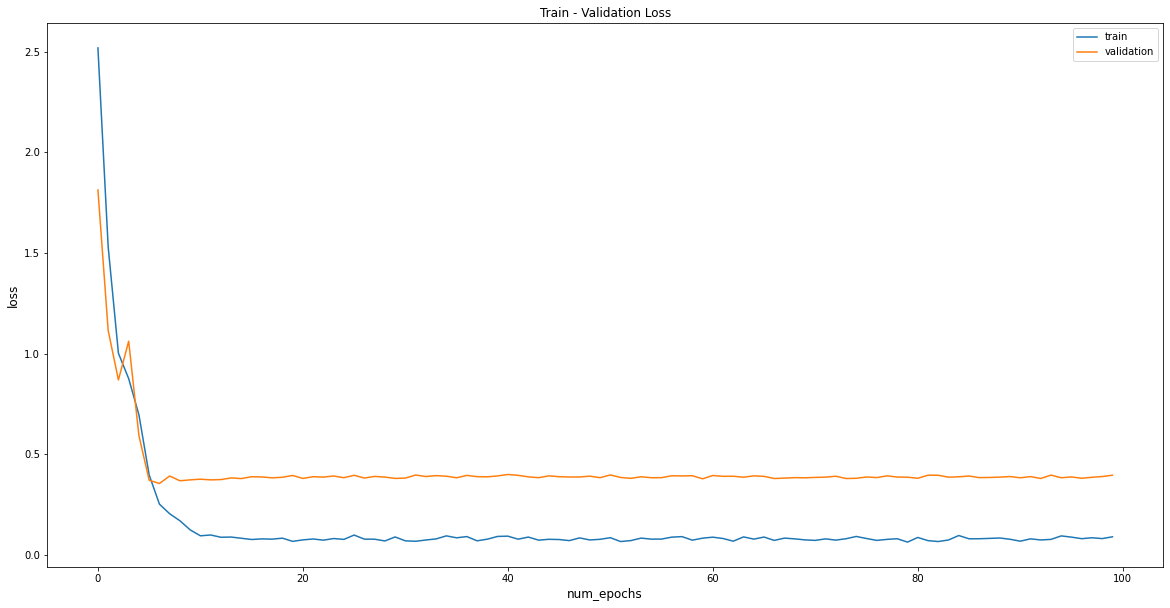

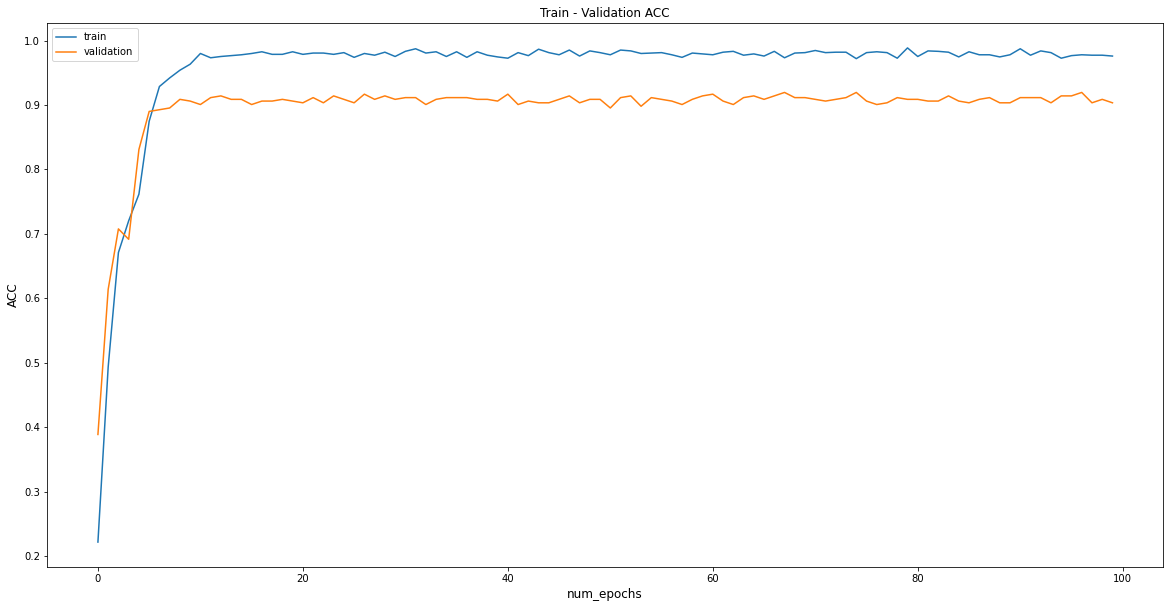

In [39]:
# Dataloaders initialization
norm_train_dataloader = torch.utils.data.DataLoader(norm_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
norm_val_dataloader = torch.utils.data.DataLoader(norm_val_dataset, batch_size=BATCH_SIZE, shuffle=True)

for i in range(3):
    inputs, classes = next(iter(norm_train_dataloader))
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

norm_dataloaders = {'train': norm_train_dataloader, 'val': norm_val_dataloader}
norm_dataset_sizes = {'train': len(norm_train_dataset), 'val': len(norm_val_dataset)}

# Train the model
norm_model_ft, norm_loss_dict, norm_acc_dict = train_model(model_ft, criterion, optimizer_ft, 
                                            exp_lr_scheduler, norm_dataloaders, norm_dataset_sizes, num_epochs=NUM_EPOCHS)

acc_loss_vis(norm_loss_dict, norm_acc_dict)

## Data Augmentation 
### Rotation

In [69]:
for class_name in os.listdir(f'old_data/train'):
    files_names = os.listdir(f'data/train/{class_name}')
    for image_name in files_names:
            if '.png' in image_name:
                sign = (random.randint(0, 1) * 2) - 1
                image_path = os.path.join(f'data/train/{class_name}', image_name)
                image = Image.open(image_path)
                rotated = image.rotate(sign * 15, fillcolor=255)
                rotated.save(os.path.join(f'data/train/{class_name}', image_name.split('.png')[0]+'_rotated.png'))

In [70]:
# Create a pytorch dataset from a directory of images
rotated_train_dataset = datasets.ImageFolder(clean_train_dir, data_transforms)
rotated_val_dataset = datasets.ImageFolder(clean_val_dir, data_transforms)

In [53]:
rotated_train_len = len(rotated_train_dataset)
print(f'The length of the rotated train dataset is: {rotated_train_len}')
rotated_val_len = len(rotated_val_dataset)
print(f'The length of the validation dataset is: {rotated_val_len}')

The length of the rotated train dataset is: 3006
The length of the validation dataset is: 372


In [71]:
# Use a prebuilt pytorch's ResNet50 model
model_ft = models.resnet50(pretrained=False)

# Fit the last layer for our specific task
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, NUM_CLASSES)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.Adam(model_ft.parameters(), lr=LR)

# Decay LR by a factor of 0.1 every 5 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.1)

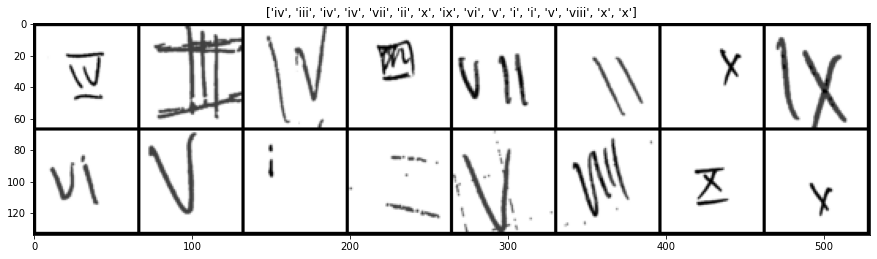

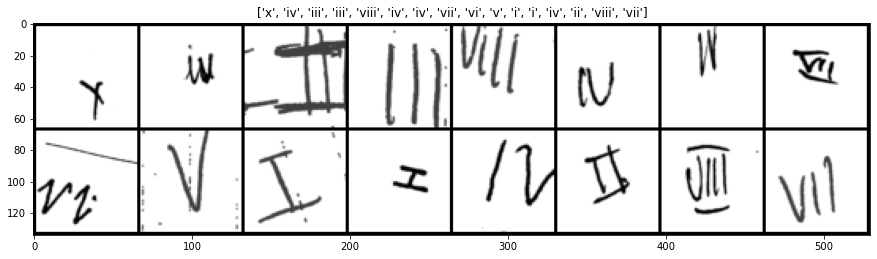

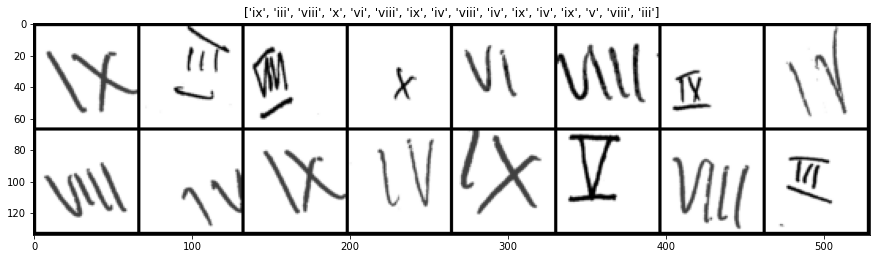

Epoch 1/100
----------


100%|█████████████████████████████████████████| 188/188 [00:15<00:00, 12.36it/s]


train Loss: 2.1962 Acc: 0.3140


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 31.03it/s]


val Loss: 1.8558 Acc: 0.5323

Epoch 2/100
----------


100%|█████████████████████████████████████████| 188/188 [00:15<00:00, 12.45it/s]


train Loss: 1.0816 Acc: 0.6334


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 30.99it/s]


val Loss: 0.6647 Acc: 0.7849

Epoch 3/100
----------


100%|█████████████████████████████████████████| 188/188 [00:14<00:00, 12.56it/s]


train Loss: 0.7767 Acc: 0.7452


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 30.52it/s]


val Loss: 1.5309 Acc: 0.4624

Epoch 4/100
----------


100%|█████████████████████████████████████████| 188/188 [00:15<00:00, 12.34it/s]


train Loss: 0.7607 Acc: 0.7661


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 31.21it/s]


val Loss: 0.5467 Acc: 0.7930

Epoch 5/100
----------


100%|█████████████████████████████████████████| 188/188 [00:15<00:00, 12.50it/s]


train Loss: 0.5149 Acc: 0.8390


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 30.91it/s]


val Loss: 0.5275 Acc: 0.8253

Epoch 6/100
----------


100%|█████████████████████████████████████████| 188/188 [00:15<00:00, 12.48it/s]


train Loss: 0.2232 Acc: 0.9335


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 28.17it/s]


val Loss: 0.3477 Acc: 0.8978

Epoch 7/100
----------


100%|█████████████████████████████████████████| 188/188 [00:15<00:00, 12.21it/s]


train Loss: 0.1471 Acc: 0.9571


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 30.83it/s]


val Loss: 0.3064 Acc: 0.9220

Epoch 8/100
----------


100%|█████████████████████████████████████████| 188/188 [00:15<00:00, 12.42it/s]


train Loss: 0.1030 Acc: 0.9727


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 31.01it/s]


val Loss: 0.3005 Acc: 0.9247

Epoch 9/100
----------


100%|█████████████████████████████████████████| 188/188 [00:15<00:00, 12.22it/s]


train Loss: 0.0722 Acc: 0.9817


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 28.57it/s]


val Loss: 0.2990 Acc: 0.9301

Epoch 10/100
----------


100%|█████████████████████████████████████████| 188/188 [00:15<00:00, 12.28it/s]


train Loss: 0.0546 Acc: 0.9864


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 28.65it/s]


val Loss: 0.3076 Acc: 0.9140

Epoch 11/100
----------


100%|█████████████████████████████████████████| 188/188 [00:15<00:00, 12.23it/s]


train Loss: 0.0453 Acc: 0.9887


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 29.19it/s]


val Loss: 0.3040 Acc: 0.9301

Epoch 12/100
----------


100%|█████████████████████████████████████████| 188/188 [00:15<00:00, 12.13it/s]


train Loss: 0.0457 Acc: 0.9887


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 30.67it/s]


val Loss: 0.3082 Acc: 0.9167

Epoch 13/100
----------


100%|█████████████████████████████████████████| 188/188 [00:15<00:00, 12.46it/s]


train Loss: 0.0367 Acc: 0.9920


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 30.86it/s]


val Loss: 0.3141 Acc: 0.9167

Epoch 14/100
----------


100%|█████████████████████████████████████████| 188/188 [00:15<00:00, 12.44it/s]


train Loss: 0.0353 Acc: 0.9937


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 28.88it/s]


val Loss: 0.3191 Acc: 0.9247

Epoch 15/100
----------


100%|█████████████████████████████████████████| 188/188 [00:15<00:00, 12.29it/s]


train Loss: 0.0321 Acc: 0.9920


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 29.67it/s]


val Loss: 0.3231 Acc: 0.9194

Epoch 16/100
----------


100%|█████████████████████████████████████████| 188/188 [00:15<00:00, 12.33it/s]


train Loss: 0.0290 Acc: 0.9953


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 29.59it/s]


val Loss: 0.3322 Acc: 0.9247

Epoch 17/100
----------


100%|█████████████████████████████████████████| 188/188 [00:15<00:00, 11.98it/s]


train Loss: 0.0273 Acc: 0.9957


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 28.31it/s]


val Loss: 0.3219 Acc: 0.9167

Epoch 18/100
----------


100%|█████████████████████████████████████████| 188/188 [00:15<00:00, 12.21it/s]


train Loss: 0.0281 Acc: 0.9957


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 31.21it/s]


val Loss: 0.3293 Acc: 0.9140

Epoch 19/100
----------


100%|█████████████████████████████████████████| 188/188 [00:15<00:00, 12.18it/s]


train Loss: 0.0320 Acc: 0.9937


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 28.68it/s]


val Loss: 0.3197 Acc: 0.9194

Epoch 20/100
----------


100%|█████████████████████████████████████████| 188/188 [00:15<00:00, 12.27it/s]


train Loss: 0.0295 Acc: 0.9950


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 30.00it/s]


val Loss: 0.3278 Acc: 0.9140

Epoch 21/100
----------


100%|█████████████████████████████████████████| 188/188 [00:15<00:00, 12.43it/s]


train Loss: 0.0277 Acc: 0.9957


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 31.04it/s]


val Loss: 0.3313 Acc: 0.9220

Epoch 22/100
----------


100%|█████████████████████████████████████████| 188/188 [00:15<00:00, 12.01it/s]


train Loss: 0.0299 Acc: 0.9937


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 27.49it/s]


val Loss: 0.3307 Acc: 0.9167

Epoch 23/100
----------


100%|█████████████████████████████████████████| 188/188 [00:15<00:00, 12.40it/s]


train Loss: 0.0277 Acc: 0.9957


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 30.15it/s]


val Loss: 0.3205 Acc: 0.9220

Epoch 24/100
----------


100%|█████████████████████████████████████████| 188/188 [00:15<00:00, 12.31it/s]


train Loss: 0.0260 Acc: 0.9963


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 29.21it/s]


val Loss: 0.3175 Acc: 0.9167

Epoch 25/100
----------


100%|█████████████████████████████████████████| 188/188 [00:15<00:00, 12.33it/s]


train Loss: 0.0320 Acc: 0.9943


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 30.91it/s]


val Loss: 0.3162 Acc: 0.9220

Epoch 26/100
----------


100%|█████████████████████████████████████████| 188/188 [00:15<00:00, 12.49it/s]


train Loss: 0.0329 Acc: 0.9933


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 30.37it/s]


val Loss: 0.3226 Acc: 0.9220

Epoch 27/100
----------


100%|█████████████████████████████████████████| 188/188 [00:15<00:00, 12.34it/s]


train Loss: 0.0259 Acc: 0.9950


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 31.01it/s]


val Loss: 0.3220 Acc: 0.9140

Epoch 28/100
----------


100%|█████████████████████████████████████████| 188/188 [00:15<00:00, 12.32it/s]


train Loss: 0.0266 Acc: 0.9963


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 29.85it/s]


val Loss: 0.3246 Acc: 0.9194

Epoch 29/100
----------


100%|█████████████████████████████████████████| 188/188 [00:15<00:00, 12.45it/s]


train Loss: 0.0284 Acc: 0.9950


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 29.29it/s]


val Loss: 0.3211 Acc: 0.9140

Epoch 30/100
----------


100%|█████████████████████████████████████████| 188/188 [00:15<00:00, 12.33it/s]


train Loss: 0.0306 Acc: 0.9940


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 30.86it/s]


val Loss: 0.3256 Acc: 0.9194

Epoch 31/100
----------


100%|█████████████████████████████████████████| 188/188 [00:15<00:00, 12.42it/s]


train Loss: 0.0346 Acc: 0.9914


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 29.36it/s]


val Loss: 0.3241 Acc: 0.9194

Epoch 32/100
----------


100%|█████████████████████████████████████████| 188/188 [00:15<00:00, 12.37it/s]


train Loss: 0.0302 Acc: 0.9943


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 30.43it/s]


val Loss: 0.3299 Acc: 0.9167

Epoch 33/100
----------


100%|█████████████████████████████████████████| 188/188 [00:15<00:00, 12.40it/s]


train Loss: 0.0269 Acc: 0.9960


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 30.42it/s]


val Loss: 0.3153 Acc: 0.9194

Epoch 34/100
----------


100%|█████████████████████████████████████████| 188/188 [00:15<00:00, 12.31it/s]


train Loss: 0.0330 Acc: 0.9930


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 29.27it/s]


val Loss: 0.3242 Acc: 0.9194

Epoch 35/100
----------


100%|█████████████████████████████████████████| 188/188 [00:15<00:00, 12.51it/s]


train Loss: 0.0293 Acc: 0.9937


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 30.92it/s]


val Loss: 0.3272 Acc: 0.9167

Epoch 36/100
----------


100%|█████████████████████████████████████████| 188/188 [00:15<00:00, 12.45it/s]


train Loss: 0.0345 Acc: 0.9930


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 29.72it/s]


val Loss: 0.3203 Acc: 0.9220

Epoch 37/100
----------


100%|█████████████████████████████████████████| 188/188 [00:15<00:00, 12.23it/s]


train Loss: 0.0268 Acc: 0.9963


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 29.02it/s]


val Loss: 0.3205 Acc: 0.9194

Epoch 38/100
----------


100%|█████████████████████████████████████████| 188/188 [00:15<00:00, 12.53it/s]


train Loss: 0.0278 Acc: 0.9957


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 31.32it/s]


val Loss: 0.3150 Acc: 0.9194

Epoch 39/100
----------


100%|█████████████████████████████████████████| 188/188 [00:15<00:00, 12.46it/s]


train Loss: 0.0292 Acc: 0.9947


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 30.93it/s]


val Loss: 0.3390 Acc: 0.9167

Epoch 40/100
----------


100%|█████████████████████████████████████████| 188/188 [00:15<00:00, 12.45it/s]


train Loss: 0.0283 Acc: 0.9947


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 31.17it/s]


val Loss: 0.3320 Acc: 0.9194

Epoch 41/100
----------


100%|█████████████████████████████████████████| 188/188 [00:14<00:00, 12.55it/s]


train Loss: 0.0283 Acc: 0.9943


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 30.13it/s]


val Loss: 0.3390 Acc: 0.9220

Epoch 42/100
----------


100%|█████████████████████████████████████████| 188/188 [00:14<00:00, 12.59it/s]


train Loss: 0.0272 Acc: 0.9953


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 29.43it/s]


val Loss: 0.3272 Acc: 0.9167

Epoch 43/100
----------


100%|█████████████████████████████████████████| 188/188 [00:15<00:00, 12.31it/s]


train Loss: 0.0289 Acc: 0.9943


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 30.95it/s]


val Loss: 0.3252 Acc: 0.9167

Epoch 44/100
----------


100%|█████████████████████████████████████████| 188/188 [00:14<00:00, 12.56it/s]


train Loss: 0.0288 Acc: 0.9950


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 31.26it/s]


val Loss: 0.3373 Acc: 0.9167

Epoch 45/100
----------


100%|█████████████████████████████████████████| 188/188 [00:15<00:00, 12.43it/s]


train Loss: 0.0325 Acc: 0.9930


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 30.94it/s]


val Loss: 0.3244 Acc: 0.9194

Epoch 46/100
----------


100%|█████████████████████████████████████████| 188/188 [00:14<00:00, 12.58it/s]


train Loss: 0.0276 Acc: 0.9940


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 31.19it/s]


val Loss: 0.3280 Acc: 0.9113

Epoch 47/100
----------


100%|█████████████████████████████████████████| 188/188 [00:14<00:00, 12.55it/s]


train Loss: 0.0286 Acc: 0.9947


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 31.03it/s]


val Loss: 0.3266 Acc: 0.9167

Epoch 48/100
----------


100%|█████████████████████████████████████████| 188/188 [00:15<00:00, 12.41it/s]


train Loss: 0.0318 Acc: 0.9950


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 28.80it/s]


val Loss: 0.3264 Acc: 0.9194

Epoch 49/100
----------


100%|█████████████████████████████████████████| 188/188 [00:15<00:00, 12.15it/s]


train Loss: 0.0277 Acc: 0.9953


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 30.76it/s]


val Loss: 0.3223 Acc: 0.9140

Epoch 50/100
----------


100%|█████████████████████████████████████████| 188/188 [00:15<00:00, 12.29it/s]


train Loss: 0.0307 Acc: 0.9950


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 31.01it/s]


val Loss: 0.3189 Acc: 0.9167

Epoch 51/100
----------


100%|█████████████████████████████████████████| 188/188 [00:14<00:00, 12.54it/s]


train Loss: 0.0306 Acc: 0.9937


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 30.45it/s]


val Loss: 0.3246 Acc: 0.9140

Epoch 52/100
----------


100%|█████████████████████████████████████████| 188/188 [00:15<00:00, 12.49it/s]


train Loss: 0.0333 Acc: 0.9920


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 29.96it/s]


val Loss: 0.3218 Acc: 0.9194

Epoch 53/100
----------


100%|█████████████████████████████████████████| 188/188 [00:15<00:00, 12.37it/s]


train Loss: 0.0331 Acc: 0.9930


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 30.91it/s]


val Loss: 0.3169 Acc: 0.9194

Epoch 54/100
----------


100%|█████████████████████████████████████████| 188/188 [00:15<00:00, 12.53it/s]


train Loss: 0.0309 Acc: 0.9927


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 30.72it/s]


val Loss: 0.3306 Acc: 0.9167

Epoch 55/100
----------


100%|█████████████████████████████████████████| 188/188 [00:15<00:00, 12.38it/s]


train Loss: 0.0294 Acc: 0.9943


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 30.73it/s]


val Loss: 0.3392 Acc: 0.9113

Epoch 56/100
----------


100%|█████████████████████████████████████████| 188/188 [00:15<00:00, 12.35it/s]


train Loss: 0.0289 Acc: 0.9947


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 30.04it/s]


val Loss: 0.3223 Acc: 0.9220

Epoch 57/100
----------


100%|█████████████████████████████████████████| 188/188 [00:15<00:00, 12.27it/s]


train Loss: 0.0305 Acc: 0.9950


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 31.29it/s]


val Loss: 0.3289 Acc: 0.9167

Epoch 58/100
----------


100%|█████████████████████████████████████████| 188/188 [00:15<00:00, 12.46it/s]


train Loss: 0.0306 Acc: 0.9923


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 30.96it/s]


val Loss: 0.3263 Acc: 0.9086

Epoch 59/100
----------


100%|█████████████████████████████████████████| 188/188 [00:15<00:00, 12.48it/s]


train Loss: 0.0280 Acc: 0.9953


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 30.84it/s]


val Loss: 0.3253 Acc: 0.9113

Epoch 60/100
----------


100%|█████████████████████████████████████████| 188/188 [00:15<00:00, 12.45it/s]


train Loss: 0.0300 Acc: 0.9937


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 31.01it/s]


val Loss: 0.3372 Acc: 0.9194

Epoch 61/100
----------


100%|█████████████████████████████████████████| 188/188 [00:15<00:00, 12.37it/s]


train Loss: 0.0306 Acc: 0.9914


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 27.87it/s]


val Loss: 0.3334 Acc: 0.9140

Epoch 62/100
----------


100%|█████████████████████████████████████████| 188/188 [00:15<00:00, 12.37it/s]


train Loss: 0.0330 Acc: 0.9917


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 31.20it/s]


val Loss: 0.3334 Acc: 0.9194

Epoch 63/100
----------


100%|█████████████████████████████████████████| 188/188 [00:15<00:00, 12.31it/s]


train Loss: 0.0333 Acc: 0.9933


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 30.58it/s]


val Loss: 0.3302 Acc: 0.9167

Epoch 64/100
----------


100%|█████████████████████████████████████████| 188/188 [00:15<00:00, 12.40it/s]


train Loss: 0.0330 Acc: 0.9923


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 29.66it/s]


val Loss: 0.3197 Acc: 0.9194

Epoch 65/100
----------


100%|█████████████████████████████████████████| 188/188 [00:15<00:00, 12.28it/s]


train Loss: 0.0276 Acc: 0.9953


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 30.47it/s]


val Loss: 0.3292 Acc: 0.9167

Epoch 66/100
----------


100%|█████████████████████████████████████████| 188/188 [00:15<00:00, 12.52it/s]


train Loss: 0.0358 Acc: 0.9910


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 30.97it/s]


val Loss: 0.3341 Acc: 0.9167

Epoch 67/100
----------


100%|█████████████████████████████████████████| 188/188 [00:15<00:00, 12.52it/s]


train Loss: 0.0306 Acc: 0.9943


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 31.26it/s]


val Loss: 0.3189 Acc: 0.9220

Epoch 68/100
----------


100%|█████████████████████████████████████████| 188/188 [00:15<00:00, 12.33it/s]


train Loss: 0.0331 Acc: 0.9933


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 30.48it/s]


val Loss: 0.3258 Acc: 0.9194

Epoch 69/100
----------


100%|█████████████████████████████████████████| 188/188 [00:15<00:00, 12.50it/s]


train Loss: 0.0308 Acc: 0.9927


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 30.89it/s]


val Loss: 0.3320 Acc: 0.9194

Epoch 70/100
----------


100%|█████████████████████████████████████████| 188/188 [00:15<00:00, 12.52it/s]


train Loss: 0.0346 Acc: 0.9920


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 31.06it/s]


val Loss: 0.3125 Acc: 0.9220

Epoch 71/100
----------


100%|█████████████████████████████████████████| 188/188 [00:15<00:00, 12.49it/s]


train Loss: 0.0341 Acc: 0.9943


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 30.34it/s]


val Loss: 0.3287 Acc: 0.9140

Epoch 72/100
----------


100%|█████████████████████████████████████████| 188/188 [00:15<00:00, 12.36it/s]


train Loss: 0.0343 Acc: 0.9937


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 30.70it/s]


val Loss: 0.3233 Acc: 0.9167

Epoch 73/100
----------


100%|█████████████████████████████████████████| 188/188 [00:15<00:00, 12.46it/s]


train Loss: 0.0323 Acc: 0.9933


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 30.94it/s]


val Loss: 0.3252 Acc: 0.9220

Epoch 74/100
----------


100%|█████████████████████████████████████████| 188/188 [00:15<00:00, 12.51it/s]


train Loss: 0.0257 Acc: 0.9967


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 30.35it/s]


val Loss: 0.3250 Acc: 0.9167

Epoch 75/100
----------


100%|█████████████████████████████████████████| 188/188 [00:15<00:00, 12.48it/s]


train Loss: 0.0276 Acc: 0.9970


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 30.68it/s]


val Loss: 0.3314 Acc: 0.9194

Epoch 76/100
----------


100%|█████████████████████████████████████████| 188/188 [00:15<00:00, 12.43it/s]


train Loss: 0.0266 Acc: 0.9963


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 30.31it/s]


val Loss: 0.3290 Acc: 0.9220

Epoch 77/100
----------


100%|█████████████████████████████████████████| 188/188 [00:15<00:00, 12.44it/s]


train Loss: 0.0325 Acc: 0.9923


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 30.21it/s]


val Loss: 0.3225 Acc: 0.9220

Epoch 78/100
----------


100%|█████████████████████████████████████████| 188/188 [00:15<00:00, 12.43it/s]


train Loss: 0.0294 Acc: 0.9937


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 30.65it/s]


val Loss: 0.3392 Acc: 0.9140

Epoch 79/100
----------


100%|█████████████████████████████████████████| 188/188 [00:15<00:00, 12.44it/s]


train Loss: 0.0316 Acc: 0.9923


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 30.91it/s]


val Loss: 0.3256 Acc: 0.9167

Epoch 80/100
----------


100%|█████████████████████████████████████████| 188/188 [00:15<00:00, 12.43it/s]


train Loss: 0.0280 Acc: 0.9943


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 30.99it/s]


val Loss: 0.3308 Acc: 0.9194

Epoch 81/100
----------


100%|█████████████████████████████████████████| 188/188 [00:15<00:00, 12.49it/s]


train Loss: 0.0295 Acc: 0.9947


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 31.04it/s]


val Loss: 0.3261 Acc: 0.9194

Epoch 82/100
----------


100%|█████████████████████████████████████████| 188/188 [00:15<00:00, 12.53it/s]


train Loss: 0.0275 Acc: 0.9963


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 31.29it/s]


val Loss: 0.3295 Acc: 0.9194

Epoch 83/100
----------


100%|█████████████████████████████████████████| 188/188 [00:15<00:00, 12.48it/s]


train Loss: 0.0305 Acc: 0.9947


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 30.76it/s]


val Loss: 0.3303 Acc: 0.9194

Epoch 84/100
----------


100%|█████████████████████████████████████████| 188/188 [00:14<00:00, 12.54it/s]


train Loss: 0.0305 Acc: 0.9927


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 31.13it/s]


val Loss: 0.3345 Acc: 0.9140

Epoch 85/100
----------


100%|█████████████████████████████████████████| 188/188 [00:14<00:00, 12.56it/s]


train Loss: 0.0276 Acc: 0.9953


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 30.64it/s]


val Loss: 0.3281 Acc: 0.9194

Epoch 86/100
----------


100%|█████████████████████████████████████████| 188/188 [00:15<00:00, 12.47it/s]


train Loss: 0.0326 Acc: 0.9930


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 30.32it/s]


val Loss: 0.3285 Acc: 0.9194

Epoch 87/100
----------


100%|█████████████████████████████████████████| 188/188 [00:15<00:00, 12.40it/s]


train Loss: 0.0318 Acc: 0.9937


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 30.14it/s]


val Loss: 0.3235 Acc: 0.9247

Epoch 88/100
----------


100%|█████████████████████████████████████████| 188/188 [00:15<00:00, 12.35it/s]


train Loss: 0.0321 Acc: 0.9933


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 29.95it/s]


val Loss: 0.3220 Acc: 0.9167

Epoch 89/100
----------


100%|█████████████████████████████████████████| 188/188 [00:15<00:00, 12.52it/s]


train Loss: 0.0306 Acc: 0.9943


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 30.08it/s]


val Loss: 0.3178 Acc: 0.9220

Epoch 90/100
----------


100%|█████████████████████████████████████████| 188/188 [00:15<00:00, 12.42it/s]


train Loss: 0.0299 Acc: 0.9957


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 30.11it/s]


val Loss: 0.3236 Acc: 0.9140

Epoch 91/100
----------


100%|█████████████████████████████████████████| 188/188 [00:15<00:00, 12.51it/s]


train Loss: 0.0311 Acc: 0.9947


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 30.95it/s]


val Loss: 0.3396 Acc: 0.9167

Epoch 92/100
----------


100%|█████████████████████████████████████████| 188/188 [00:15<00:00, 12.34it/s]


train Loss: 0.0289 Acc: 0.9960


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 30.10it/s]


val Loss: 0.3219 Acc: 0.9167

Epoch 93/100
----------


100%|█████████████████████████████████████████| 188/188 [00:15<00:00, 12.41it/s]


train Loss: 0.0271 Acc: 0.9957


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 30.46it/s]


val Loss: 0.3363 Acc: 0.9086

Epoch 94/100
----------


100%|█████████████████████████████████████████| 188/188 [00:15<00:00, 12.46it/s]


train Loss: 0.0344 Acc: 0.9923


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 30.61it/s]


val Loss: 0.3286 Acc: 0.9194

Epoch 95/100
----------


100%|█████████████████████████████████████████| 188/188 [00:15<00:00, 12.49it/s]


train Loss: 0.0314 Acc: 0.9927


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 31.05it/s]


val Loss: 0.3242 Acc: 0.9194

Epoch 96/100
----------


100%|█████████████████████████████████████████| 188/188 [00:15<00:00, 12.50it/s]


train Loss: 0.0266 Acc: 0.9950


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 30.80it/s]


val Loss: 0.3287 Acc: 0.9113

Epoch 97/100
----------


100%|█████████████████████████████████████████| 188/188 [00:15<00:00, 12.18it/s]


train Loss: 0.0279 Acc: 0.9953


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 30.39it/s]


val Loss: 0.3350 Acc: 0.9167

Epoch 98/100
----------


100%|█████████████████████████████████████████| 188/188 [00:15<00:00, 12.44it/s]


train Loss: 0.0301 Acc: 0.9947


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 31.12it/s]


val Loss: 0.3258 Acc: 0.9167

Epoch 99/100
----------


100%|█████████████████████████████████████████| 188/188 [00:15<00:00, 12.40it/s]


train Loss: 0.0311 Acc: 0.9937


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 29.50it/s]


val Loss: 0.3366 Acc: 0.9140

Epoch 100/100
----------


100%|█████████████████████████████████████████| 188/188 [00:15<00:00, 12.15it/s]


train Loss: 0.0263 Acc: 0.9967


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 29.27it/s]


val Loss: 0.3227 Acc: 0.9140

Training complete in 26m 37s
Best val Acc: 0.930108


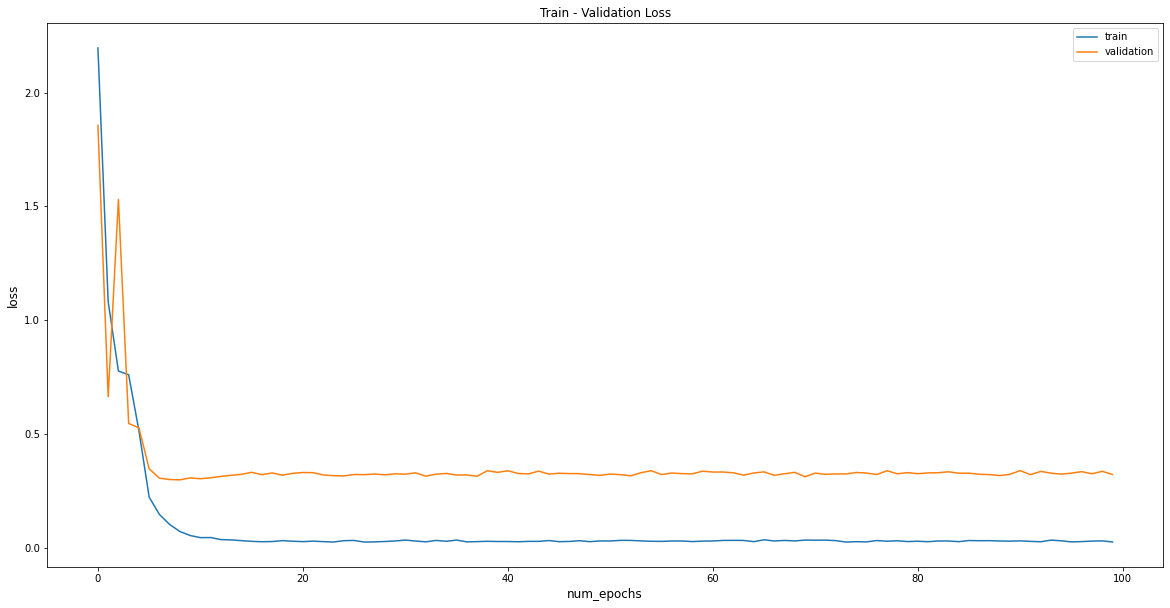

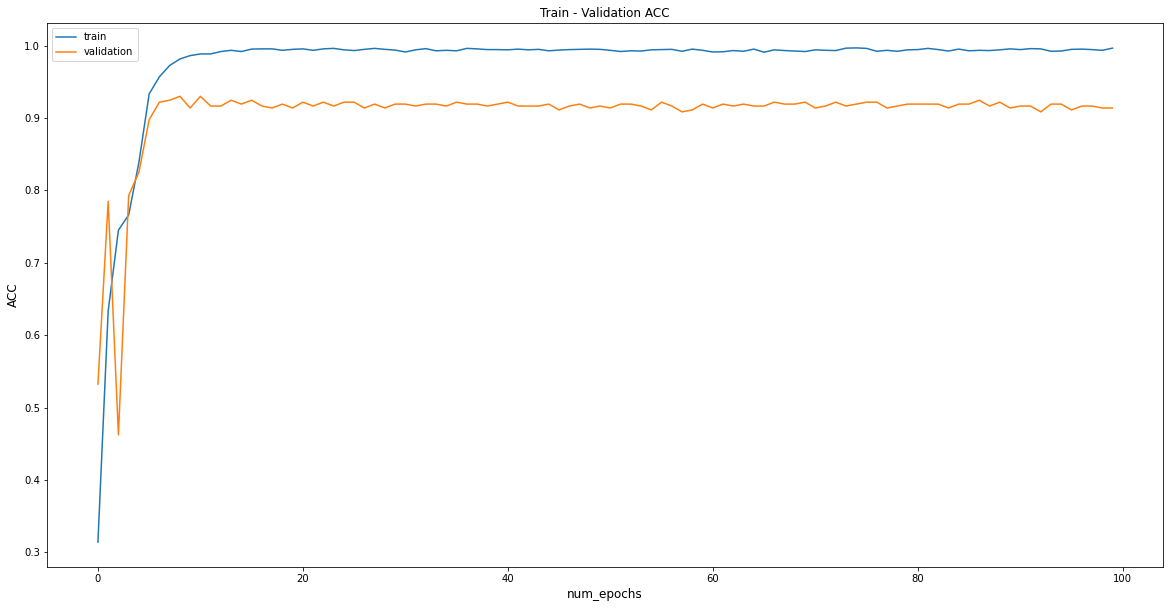

In [72]:
# Dataloaders initialization
rotated_train_dataloader = torch.utils.data.DataLoader(rotated_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
rotated_val_dataloader = torch.utils.data.DataLoader(rotated_val_dataset, batch_size=BATCH_SIZE, shuffle=True)

for i in range(3):
    inputs, classes = next(iter(rotated_train_dataloader))
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

rotated_dataloaders = {'train': rotated_train_dataloader, 'val': rotated_val_dataloader}
rotated_dataset_sizes = {'train': len(rotated_train_dataset), 'val': len(rotated_val_dataset)}

# Train the model
rotated_model_ft, rotated_loss_dict, rotated_acc_dict = train_model(model_ft, criterion, optimizer_ft, 
                                            exp_lr_scheduler, rotated_dataloaders, rotated_dataset_sizes, num_epochs=NUM_EPOCHS)

acc_loss_vis(rotated_loss_dict, rotated_acc_dict)